# EDA and Cleaning of 2018 BRFSS Dataset

In [1]:
import numpy as np
import pandas as pd
from EDA_utils import *

In [2]:
# IQR outlier clipper, outliers < Q1 - 1.5IQR or > Q3 + 1.5IQR
def iqr_outlier_clipper(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    l = q1 - 1.5 * iqr
    u = q3 + 1.5 * iqr
    return x.clip(lower=l, upper=u)

# Load Data

In [3]:
df = pd.read_csv('Data/LLCP2018.csv.gz')
df_ori = df.copy()

# y variables - Diabetes Indicator and CVD Indicator

Cleaning Steps:
[1] 2 Pregnancy Diabetes -> 1 Yes
[2] 3 No -> 0 No
[3] 4 pre-diabetes -> 0 No
[4] 7 Don't know / Not sure -> NA
[5] 9 Refused -> NA
There are 856 (0.20%) missing records.


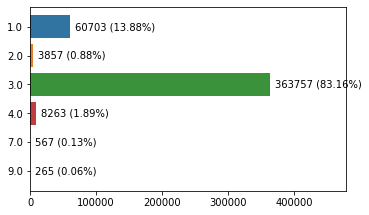

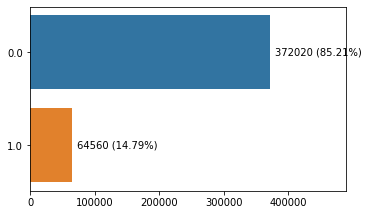

In [4]:
# Diabetes Indicator - Whether a person currently has diabetes
# Variable - DIABETE3
df = clean_and_report(
    df, 'DIABETE3', 
    [
        (lambda x: x == 2, lambda x: 1, "2 Pregnancy Diabetes -> 1 Yes"),
        (lambda x: x == 3, lambda x: 0, "3 No -> 0 No"),
        (lambda x: x == 4, lambda x: 0, "4 pre-diabetes -> 0 No"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> NA"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> NA")
    ], var_description='(Ever told) you have diabetes?'
)

There are 0 (0.00%) missing records.


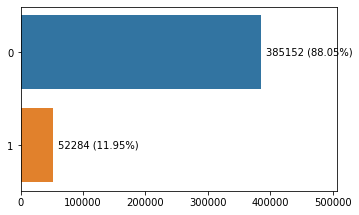

In [5]:
# CVD Indicator - Getting one of
# Heart Attack (CVDINFR4)
# Angina or Coronary Heart Disease (CVDCRHD4)
# Stroke (CVDSTRK3)
# Combine these variables by OR, get new variable CVD
# Drop used variables
df['CVD'] = ((df['CVDINFR4'] == 1) | (df['CVDCRHD4'] == 1) | (df['CVDSTRK3'] == 1)).astype(int)
df = clean_and_report(
    df, 'CVD', [], 
    var_description='Do you have cardiovascular diseases? (Hypertension excluded)',
    additional_reports=['CVD variable is combination of Heart Attack (CVDINFR4), Angina or Coronary Heart Disease (CVDCRHD4) and Stroke (CVDSTRK3).']
)
df = df.drop(columns=['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', '_MICHD'])

# Sample Weight Variables

In [6]:
# Drop unused sample weight variables
# _LLCPWT (final weight)
# _STSTR (Sample Design Stratification Variable)
# _STRWT (Stratum Weight)
# _RAWRAKE (Raw weighting factor used in raking)
# _WT2RAKE (Design weight use in raking)
# _CLLCPWT (Final child weight)
# _LLCPWT2 (Truncated design weight used in adult combined land line and cell phone raking)
df = df.drop(columns=['_LLCPWT', '_STSTR', '_STRWT', '_RAWRAKE', '_WT2RAKE', '_CLLCPWT', '_LLCPWT2'])

# X Variables

## Diabetes Related
These variables are related to or depended on DIABETE3, the y variable needed to be predicted. Might consider removing them from X when predicting diabetes indicator.

Cleaning Steps:
[1] 98 Don't know / Not sure -> Missing
[2] 99 Refused -> Missing
There are 380524 (86.99%) missing records.


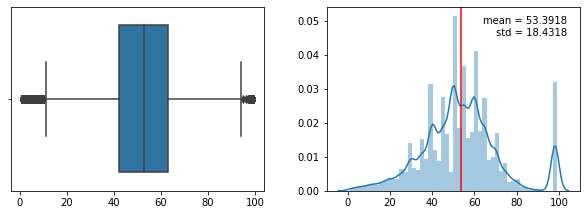

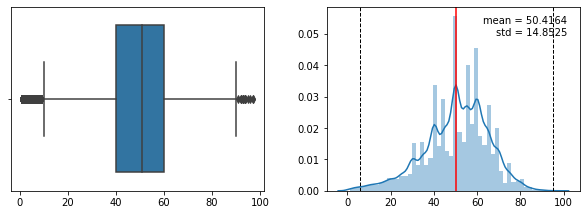

In [7]:
# DIABAGE2
df = clean_and_report(
    df, 'DIABAGE2', 
    [
        (lambda x: x == 98, lambda x: np.nan, "98 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ],
    var_description='Age When Told Had Diabetes'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 241678 (55.25%) missing records.


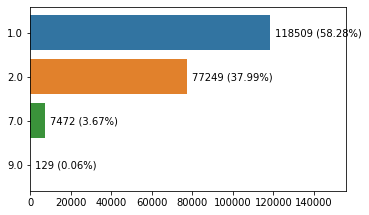

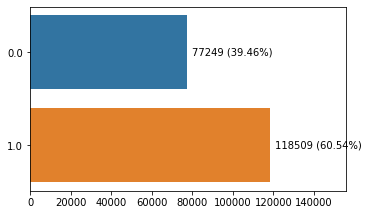

In [8]:
# PDIABTST
df = clean_and_report(
    df, 'PDIABTST', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ],
    var_description='Had a test for high blood sugar or diabetes in the past three years?'
)

Cleaning Steps:
[1] 2 Yes during pregnancy -> 1
[2] 3 No -> 0
[3] 7 Don't know / Not sure -> Missing
[4] 9 Refused -> Missing
There are 235052 (53.73%) missing records.


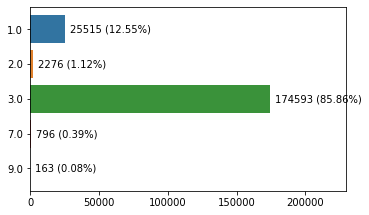

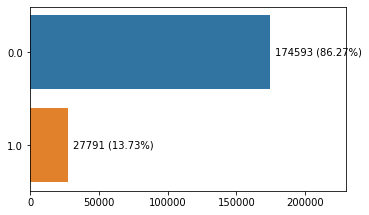

In [9]:
# PREDIAB1
df = clean_and_report(
    df, 'PREDIAB1', 
    [
        (lambda x: x == 2, lambda x: 1, "2 Yes during pregnancy -> 1"),
        (lambda x: x == 3, lambda x: 0, "3 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ],
    var_description='Ever been told by a doctor or other health professional that you have pre-diabetes or borderline diabetes?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 9 Refused -> Missing
There are 419610 (95.92%) missing records.


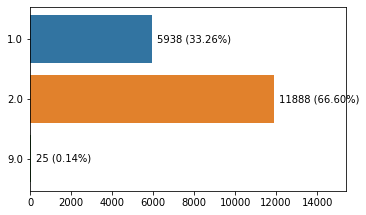

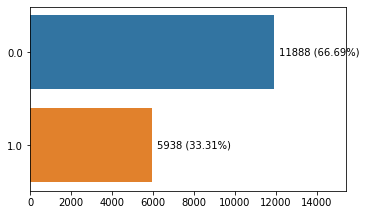

In [10]:
# INSULIN
df = clean_and_report(
    df, 'INSULIN', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Now Taking Insulin'
)

Cleaning Steps:
[1] 1XX means XX times per day. -> x - 100
[2] 2XX means XX times per week, convert to per day. -> (x - 200) / 7
[3] 3XX means XX times per month, convert to per day. -> (x - 300) / 30
[4] 4XX means XX times per year, convert to per day. -> (x - 400) / 365
[5] 777 Dont know / Not sure -> NA
[6] 888 Never -> 0
[7] 999 Refused -> NA
[8] Values out of 1.5 IQR -> Clip values
There are 420068 (96.03%) missing records.


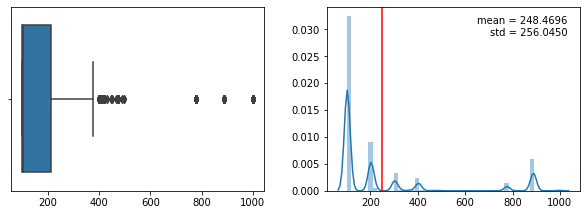

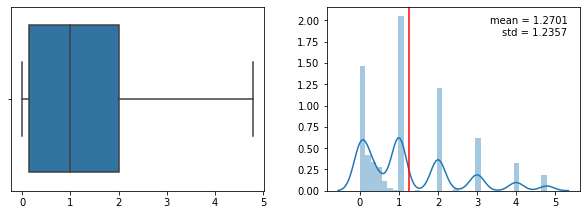

In [11]:
# BLDSUGAR
df = clean_and_report(
    df, 'BLDSUGAR', [
        (lambda x: (x > 100) & (x < 200), lambda x: (x - 100), '1XX means XX times per day. -> x - 100'),
        (
            lambda x: (x > 200) & (x < 300), 
            lambda x: (x - 200) / 7, 
            '2XX means XX times per week, convert to per day. -> (x - 200) / 7'
        ),
        (
            lambda x: (x > 300) & (x < 400),
            lambda x: (x - 300) / 30, 
            '3XX means XX times per month, convert to per day. -> (x - 300) / 30'
        ),
        (
            lambda x: (x > 400) & (x < 500), 
            lambda x: (x - 400) / 365, 
            '4XX means XX times per year, convert to per day. -> (x - 400) / 365'
        ),
        (lambda x: x == 777, lambda x: np.nan, '777 Dont know / Not sure -> NA'),
        (lambda x: x == 888, lambda x: 0, '888 Never -> 0'),
        (lambda x: x == 999, lambda x: np.nan, '999 Refused -> NA'),
        (lambda x: ~x.isna(), iqr_outlier_clipper, 'Values out of 1.5 IQR -> Clip values')
    ], var_description='How Often Check Blood for Glucose per day'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Don't know / Not sure -> Missing
[3] 99 Refused -> Missing
[4] Values out of 1.5 IQR -> Clip values
There are 420205 (96.06%) missing records.


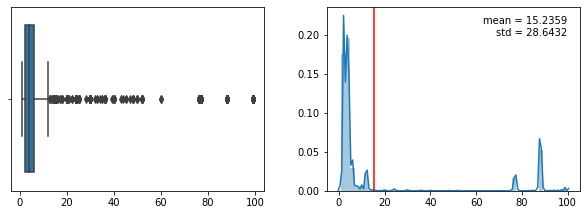

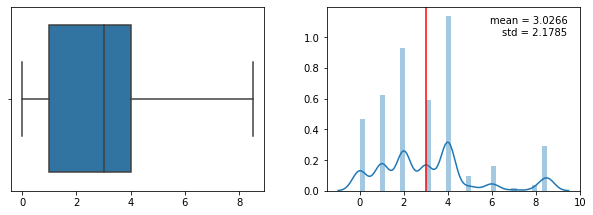

In [12]:
# DOCTDIAB
df = clean_and_report(
    df, 'DOCTDIAB', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing"),
        (lambda x: ~x.isna(), iqr_outlier_clipper, 'Values out of 1.5 IQR -> Clip values')
    ], 
    col_type='Continuous', 
    var_description='Times seen health professional for diabetes in the past year'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 98 Never heard of -> 0
[3] 77 Don't know / Not sure -> Missing
[4] 99 Refused -> Missing
[5] Values out of 1.5 IQR -> Clip values
There are 420615 (96.15%) missing records.


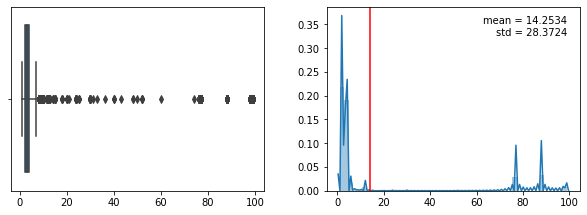

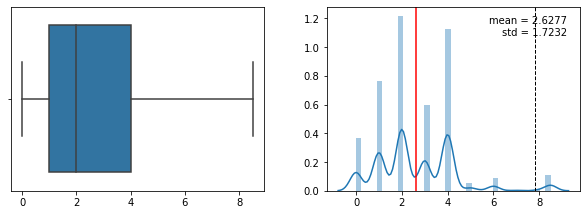

In [13]:
# CHKHEMO3
df = clean_and_report(
    df, 'CHKHEMO3', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 98, lambda x: 0, "98 Never heard of -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing"),
        (lambda x: ~x.isna(), iqr_outlier_clipper, 'Values out of 1.5 IQR -> Clip values')
    ], col_type='Continuous',
    var_description='Times Checked for Glycosylated Hemoglobin (HbA1C) in the past year'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Don't know / Not sure -> Missing
[3] 99 Refused -> Missing
[4] Values out of 1.5 IQR -> NA
There are 420286 (96.08%) missing records.


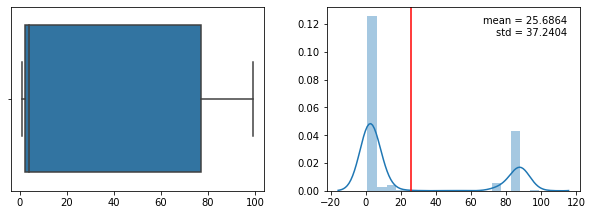

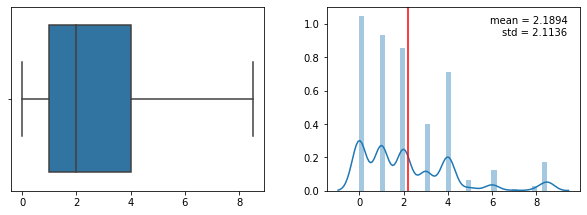

In [14]:
# FEETCHK
df = clean_and_report(
    df, 'FEETCHK', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing"),
        (lambda x: ~x.isna(), iqr_outlier_clipper, 'Values out of 1.5 IQR -> NA')
    ], col_type='Continuous',
    var_description='Times Feet Check for Sores/irritations in the past year'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 419963 (96.01%) missing records.


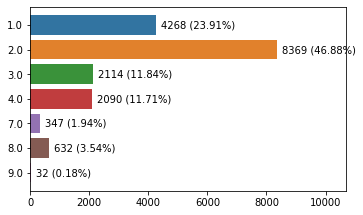

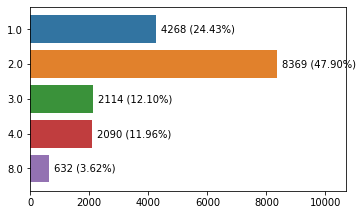

In [15]:
# EYEEXAM1
df = clean_and_report(
    df, 'EYEEXAM1', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing"),
    ], var_description='Last Eye Exam Where Pupils Were Dilated'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 419865 (95.98%) missing records.


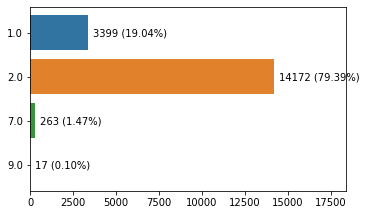

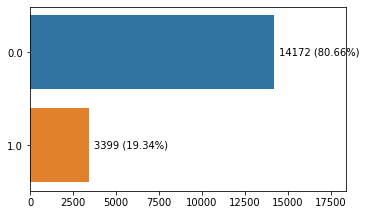

In [16]:
# DIABEYE
df = clean_and_report(
    df, 'DIABEYE', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Ever Told Diabetes Has Affected Eyes'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 419665 (95.94%) missing records.


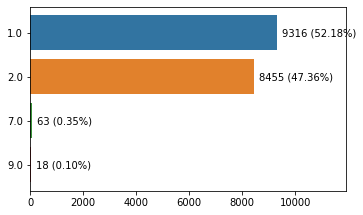

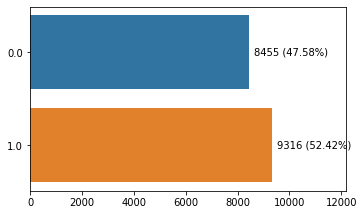

In [17]:
# DIABEDU
df = clean_and_report(
    df, 'DIABEDU', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Ever Taken Class in Managing Diabetes'
)

## Survey Related

In [18]:
# Variables not used and dropped
# FMONTH - File Month
# IDATE - Interview Date (Already have interview y/m/d)
# DISPCODE - Final Disposition (Completed / Partial Completed)
# SEQNO - Annual Sequence Number
# _PSU - Primary Sampling Unit
# QSTVER - Questionnaire Version Identifier
# QSTLANG - Questionnaire Language
# _DUALUSE - Dual Phone Use Categories
# _DUALCOR - Dual Phone Use Correction Factor
df = df.drop(columns=[
    'FMONTH', 'IDATE', 'DISPCODE', 'SEQNO', '_PSU', 
    'QSTVER', 'QSTLANG', '_DUALUSE', '_DUALCOR'
])

There are 0 (0.00%) missing records.


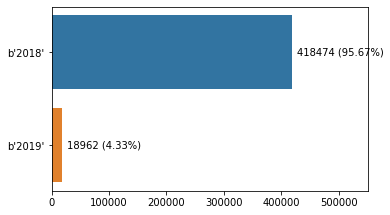

In [19]:
# IYEAR
df = clean_and_report(df, 'IYEAR', [], var_description='Interview Year')

There are 0 (0.00%) missing records.


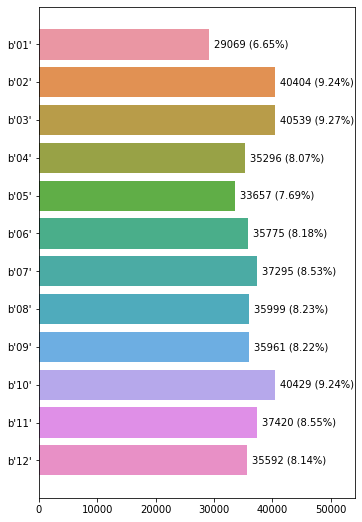

In [20]:
# IMONTH
df = clean_and_report(
    df, 'IMONTH', [], 
    col_type='Catgorical', fig_size=(5, 8),
    var_description='Interview Month'
)

There are 0 (0.00%) missing records.


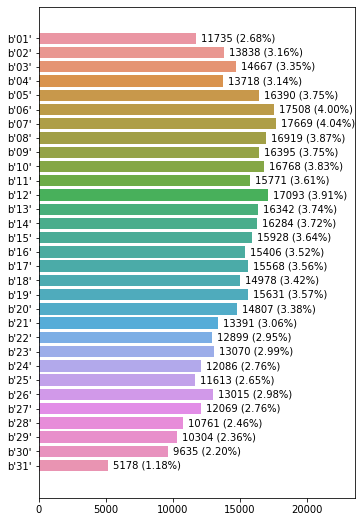

In [21]:
# IDAY
df = clean_and_report(
    df, 'IDAY', [], col_type='Catgorical', fig_size=(5, 8), var_description='Interview Day'
)

## Demographics

In [22]:
# Variables not used, drop
# CTELENM1 - Correct landline phone number? (Same with CELLPON5)
# CTELNUM1 - Correct cell phone Number? (Same with CELLPON5)
# CELLFON4 - Is this a cell telephone? (Same with CELLPON5)
# LADULT - Are you 18 years of age or older? (landline, answer male / female)
# CADULT - Are you 18 years of age or older? (cellphone, answer male / female)
# NUMMEN - How many of household adults are men? (only has landline version)
# NUMWOMEN - How many of household adults are women? (only has landline version)
# SAFETIME - Is this a safe time to talk with you? (All cell phone users put yes)
# _EDUCAG - Computed education level (redundant)
# _INCOMG - Computed income level (redundant)
# _PRACE1 - Computed Preferred Race (Use _RACE)
# _MRACE1 - Calculated multiracial race categorization (Use _RACE)
# _HISPANC - Hispanic, Latino/a, or Spanish origin calculated variable (Use _RACE)
# _IMPRACE - Imputed race/ethnicity value
# _RACEG21 - White non-Hispanic race group
# _RACEGR3 - Five-level race/ethnicity category
# _RACE_G1 - Race groups used for internet prevalence tables
# _AGE65YR - Two-level age category (Use _AGEG5YR)
# _AGE80 - Imputed Age value collapsed above 80 (Use _AGEG5YR)
# _AGE_G - Six-level imputed age category (Use _AGEG5YR)
# _CHLDCNT - Computed number of children in household
df = df.drop(columns=[
    'CTELENM1', 'CTELNUM1', 'CELLFON4', 'LADULT', 'CADULT',
    'NUMMEN', 'NUMWOMEN', 'SAFETIME', '_EDUCAG', '_INCOMG',
    '_PRACE1', '_MRACE1', '_HISPANC', '_RACEG21', '_RACEGR3',
    '_RACE_G1', '_AGE65YR', '_AGE_G', '_AGE80', '_CHLDCNT',
    '_IMPRACE'
])

There are 0 (0.00%) missing records.


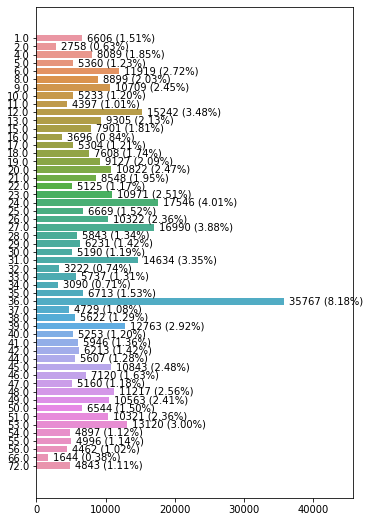

In [23]:
# _STATE
df = clean_and_report(
    df, '_STATE', [], col_type='Categorical', fig_size=(5, 8), var_description='State FIPS Code'
)

Cleaning Steps:
[1] 2 No -> 0
There are 2 (0.00%) missing records.


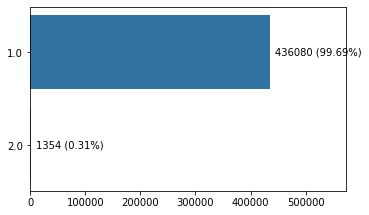

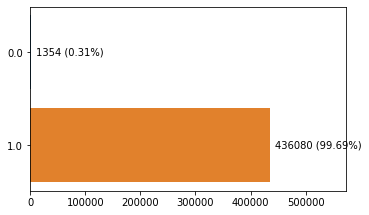

In [24]:
# PVTRESD1 + PVTRESD3, live in private residence?
df['PVTRESD'] = df['PVTRESD1'].fillna(df['PVTRESD3'])
df = df.drop(columns=['PVTRESD1', 'PVTRESD3'])
df = clean_and_report(
    df, 'PVTRESD', 
    [(lambda x: x == 2, lambda x: 0, "2 No -> 0")],
    var_description='Is this a private residence?',
    additional_reports=[
        'PVTRESD is a combination of PVTRESD1 (landline) and PVTRESD3 (cellphone).'
    ]
)

Cleaning Steps:
[1] Missing -> 0 Not in college housing
There are 0 (0.00%) missing records.


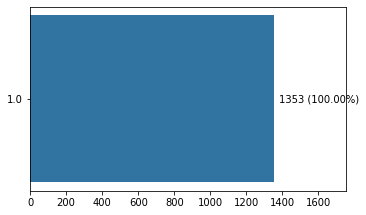

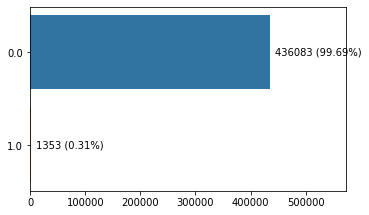

In [25]:
# COLGHOUS + CCLGHOUS, Do you live in college housing?
df['COLGHOUS'] = df['COLGHOUS'].fillna(df['CCLGHOUS'])
df = df.drop(columns=['CCLGHOUS'])
df = clean_and_report(
    df, 'COLGHOUS', 
    [(lambda x: x.isna(), lambda x: 0, "Missing -> 0 Not in college housing")],
    var_description='Do you live in college housing?',
    additional_reports=[
        'COLGHOUS is a combination of COLGHOUS (landline) and CCLGHOUS (cellphone).'
    ]
)

Cleaning Steps:
[1] 2 No -> 0
There are 3 (0.00%) missing records.


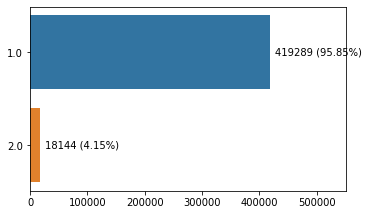

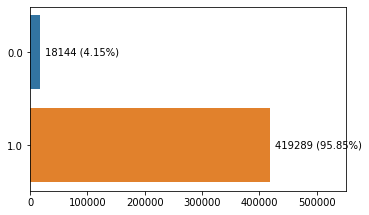

In [26]:
# STATERE1 + CSTATE1, Do you currently live in state?
df['STATERE'] = df['STATERE1'].fillna(df['CSTATE1'])
df = df.drop(columns=['STATERE1', 'CSTATE1'])
df = clean_and_report(
    df, 'STATERE', 
    [(lambda x: x == 2, lambda x: 0, "2 No -> 0")],
    var_description='Do you currently live in state?',
    additional_reports=[
        'STATERE is a combination of STATERE1 (landline) and CSTATE1 (cellphone)'
    ]
)

Cleaning Steps:
[1] 2 Nonmetropolitan -> 0
There are 6487 (1.48%) missing records.


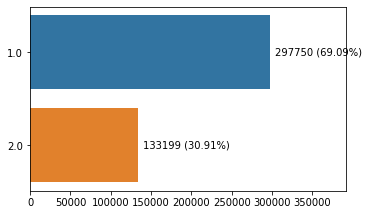

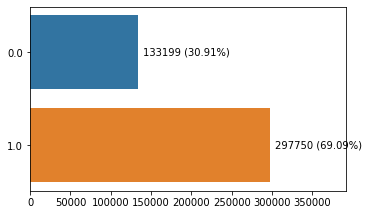

In [27]:
# _METSTAT, Metropolitan Status
clean_steps_METSTAT = [
    (lambda x: x == 2, lambda x: 0, '2 Nonmetropolitan -> 0')
]
df = clean_and_report(df, '_METSTAT', clean_steps_METSTAT, var_description='Metropolitan Status')

Cleaning Steps:
[1] 2 Rural -> 0
There are 6487 (1.48%) missing records.


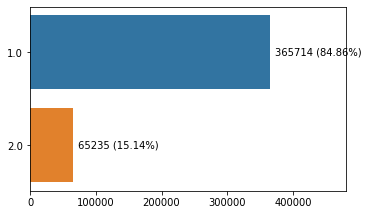

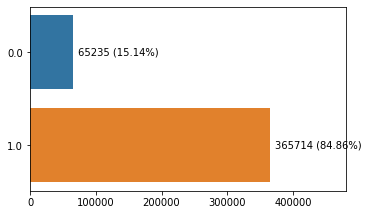

In [28]:
# _URBSTAT, Urban/Rural Status
clean_steps_URBSTAT = [
    (lambda x: x == 2, lambda x: 0, '2 Rural -> 0')
]
df = clean_and_report(df, '_URBSTAT', clean_steps_URBSTAT, var_description='Urban/Rural Status')

There are 275653 (63.02%) missing records.


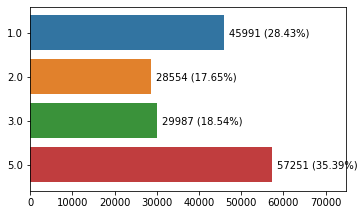

In [29]:
# MSCODE, Metropolitan Status Code
df = clean_and_report(df, 'MSCODE', [], var_description='Metropolitan Status Code')

Cleaning Steps:
[1] 6 or more -> 6
There are 1466 (0.34%) missing records.


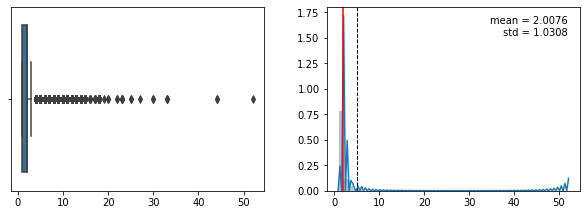

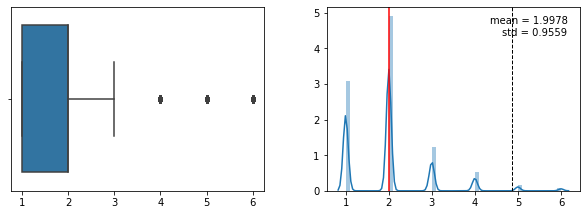

In [30]:
# NUMADULT + HHADULT, number of adults in household
df['HHADULT'] = df['HHADULT'].replace({77: np.nan, 99: np.nan})
df['NUMADULT'] = df['NUMADULT'].fillna(df['HHADULT'])
df = df.drop(columns=['HHADULT'])
df = clean_and_report(
    df, 'NUMADULT', [(lambda x: x > 6, lambda x: 6, "6 or more -> 6")],
    col_type='Continuous',
    var_description='Number of Adults in Household',
    additional_reports=[
        'NUMADULT is a combination of NUMADULT (landline) and HHADULT (cellphone).'
    ]
)

Cleaning Steps:
[1] Missing -> 0 No
There are 0 (0.00%) missing records.


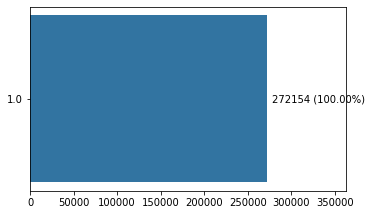

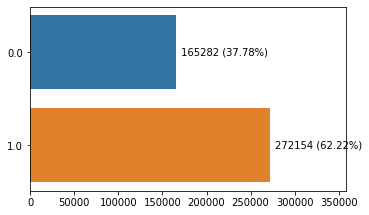

In [31]:
# CELLFON5
df = clean_and_report(
    df, 'CELLFON5', 
    [(lambda x: x.isna(), lambda x: 0, "Missing -> 0 No")],
    var_description='Is this a cell phone?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 165813 (37.91%) missing records.


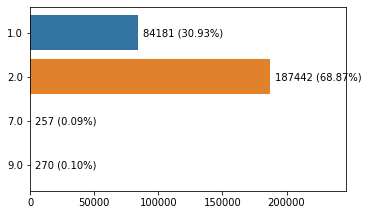

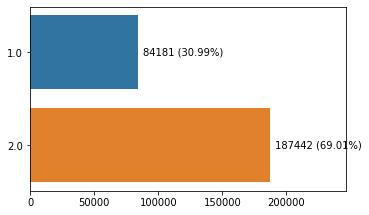

In [32]:
# LANDLINE
df = clean_and_report(
    df, 'LANDLINE', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do you also have a landline telephone?'
)

Cleaning Steps:
[1] 2 Female -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 1113 (0.25%) missing records.


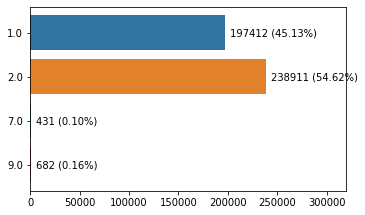

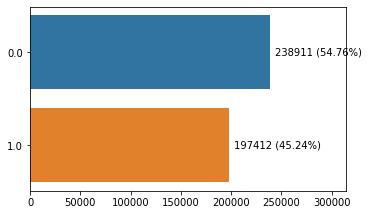

In [33]:
# SEX1
df = clean_and_report(
    df, 'SEX1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 Female -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Respondents Gender'
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 212449 (48.57%) missing records.


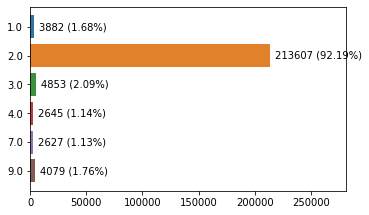

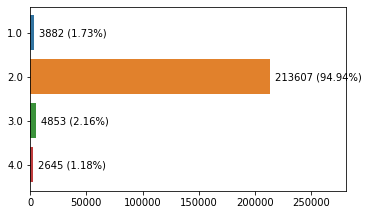

In [34]:
# Combine SOMALE and SOFEMALE to SO - Sexual Orientation
df['SO'] = df['SOMALE'].fillna(df['SOFEMALE'])
df = df.drop(columns=['SOMALE', 'SOFEMALE'])
clean_steps_SO = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'SO', clean_steps_SO, 
    var_description='Sexual orientation',
    additional_reports=['SO is combined by SOMALE and SOFEMALE']
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 205781 (47.04%) missing records.


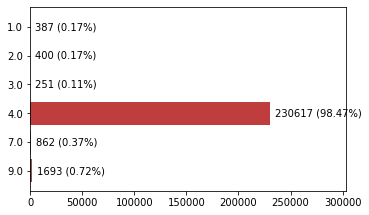

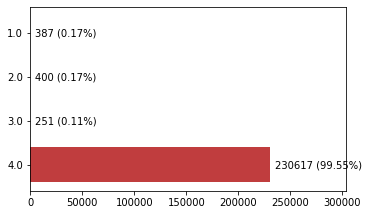

In [35]:
# Cleaning TRNSGNDR - Do you consider yourself to be transgender?
clean_steps_TRNSGNDR = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'TRNSGNDR', clean_steps_TRNSGNDR, 
    var_description='Do you consider yourself to be transgender?'
)

Cleaning Steps:
[1] 9 Refused -> Missing
There are 3259 (0.75%) missing records.


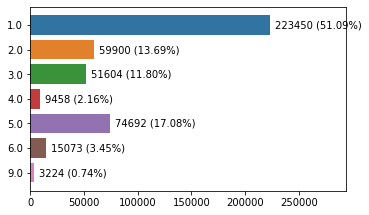

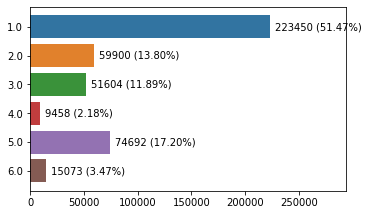

In [36]:
# MARITAL
df = clean_and_report(
    df, 'MARITAL', 
    [
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Marital Status'
)

Cleaning Steps:
[1] 9 Refused -> Missing
There are 1621 (0.37%) missing records.


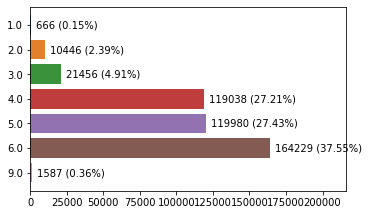

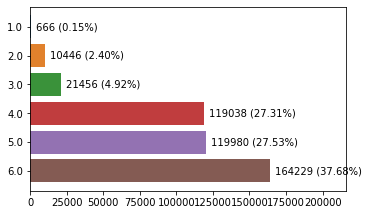

In [37]:
# EDUCA
df = clean_and_report(
    df, 'EDUCA', [(lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")],
    var_description='Education Level'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 3147 (0.72%) missing records.


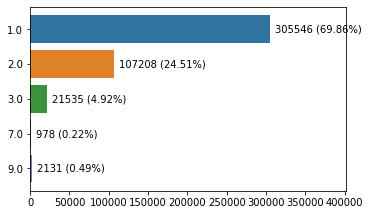

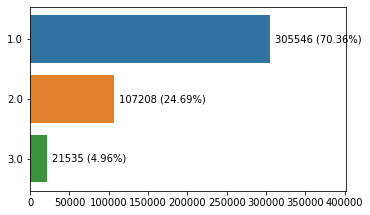

In [38]:
# RENTHOM1
df = clean_and_report(
    df, 'RENTHOM1', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do you own or rent your home?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 273113 (62.43%) missing records.


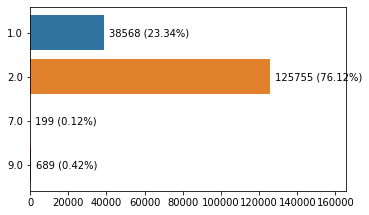

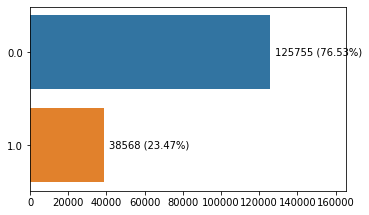

In [39]:
# NUMHHOL3
df = clean_and_report(
    df, 'NUMHHOL3', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do you have more than one telephone number in your household?'
)

Cleaning Steps:
[1] 8 None -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 399848 (91.41%) missing records.


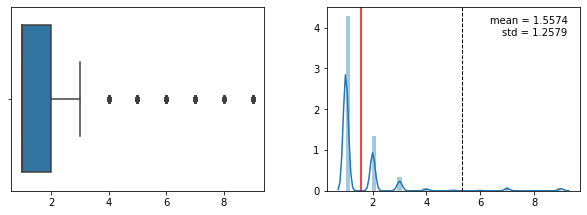

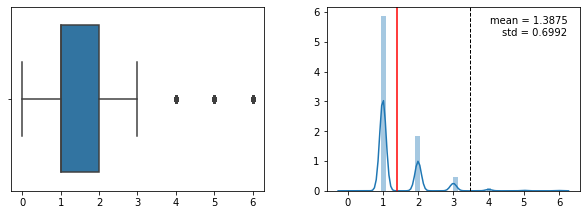

In [40]:
# NUMPHON3
df = clean_and_report(
    df, 'NUMPHON3', 
    [
        (lambda x: x == 8, lambda x: 0, "8 None -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], col_type='Continuous', 
    var_description='How many of your household telephone numbers are residential numbers?'
)

Cleaning Steps:
[1] 8 None -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 274391 (62.73%) missing records.


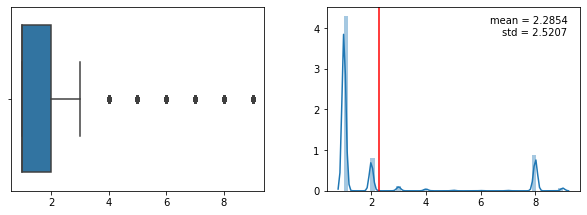

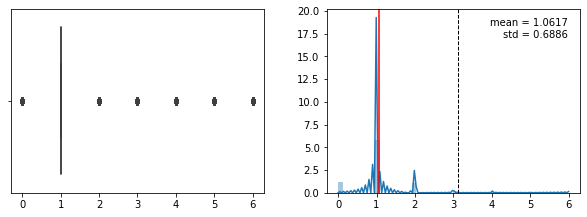

In [41]:
# CPDEMO1B
df = clean_and_report(
    df, 'CPDEMO1B', 
    [
        (lambda x: x == 8, lambda x: 0, "8 None -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], col_type='Continuous',
    var_description='How many cell phones do you have for personal use?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 1416 (0.32%) missing records.


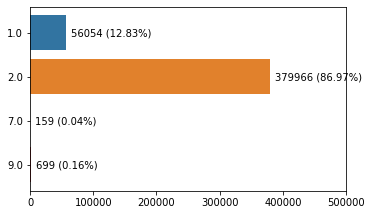

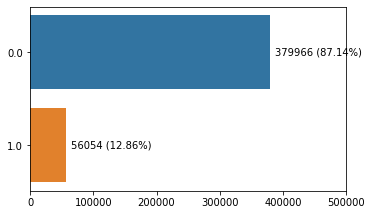

In [42]:
# VETERAN3
df = clean_and_report(
    df, 'VETERAN3', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Are you a veteran?'
)

Cleaning Steps:
[1] 9 Refused -> Missing
There are 4969 (1.14%) missing records.


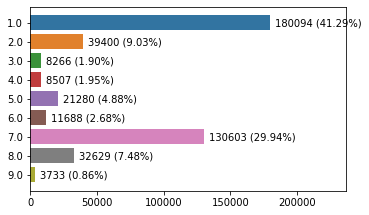

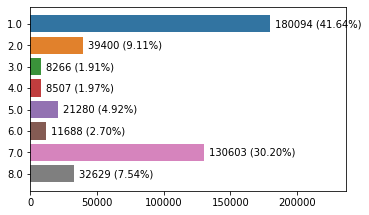

In [43]:
# EMPLOY1
df = clean_and_report(
    df, 'EMPLOY1', 
    [
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Employment Status'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 99 Refused -> NA
There are 4746 (1.08%) missing records.


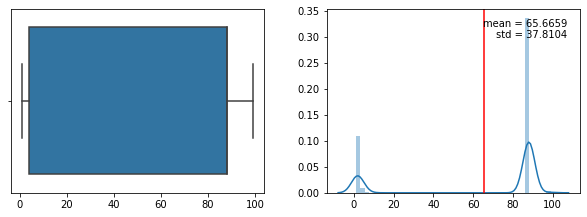

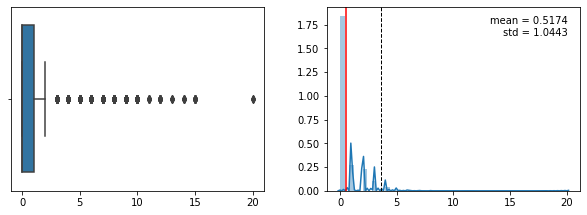

In [44]:
# CHILDREN
df = clean_and_report(
    df, 'CHILDREN', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> NA"),
    ], col_type='Continuous', var_description='Number of Children in Household'
)

Cleaning Steps:
[1] 77 Don't know / Not sure -> Missing
[2] 99 Refused -> Missing
There are 76118 (17.40%) missing records.


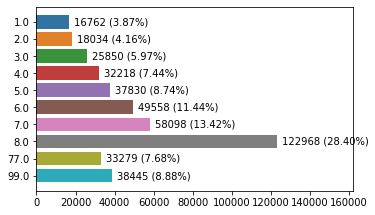

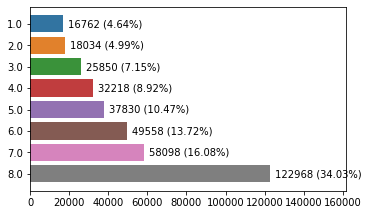

In [45]:
# INCOME2
df = clean_and_report(
    df, 'INCOME2', 
    [
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], var_description='Household Income Level'
)

Cleaning Steps:
[1] 9 Don’t know/Not sure/Refused -> NA
There are 8481 (1.94%) missing records.


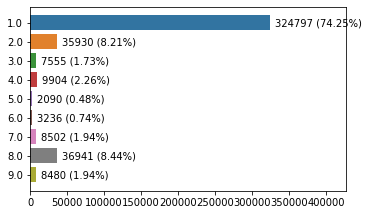

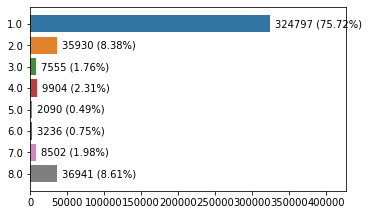

In [46]:
# cleaning _RACE Race/ethnicity categories
clean_steps_RACE = [
    (lambda x: x == 9, lambda x: np.nan, '9 Don’t know/Not sure/Refused -> NA'),
]
df = clean_and_report(
    df, '_RACE', clean_steps_RACE, var_description='Race/ethnicity categories'
)

Cleaning Steps:
[1] 14 Refused, do not know or missing -> NA
There are 8472 (1.94%) missing records.


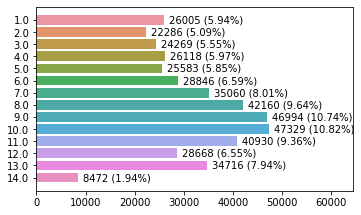

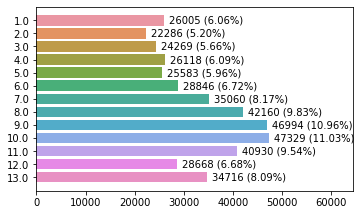

In [47]:
# For AGE, only use _AGEG5YR (Reported age in five-year age categories calculated variable)
clean_steps_AGEG5YR = [
    (lambda x: x == 14, lambda x: np.nan, '14 Refused, do not know or missing -> NA'),
]
df = clean_and_report(df, '_AGEG5YR', clean_steps_AGEG5YR, var_description='Reported age in five-year age categories')

## Health Status and Conditions

In [48]:
# Variables to drop
# _RFHLTH - Adults with good or better health (Binned version of GENHLTH)
# WEIGHT2 - Reported Weight in Pounds (Use WTKG3, weight in kg)
# HEIGHT3 - Reported Height in Feet and Inches (Use HTM4, height in m)
# HTIN4 - Reported Height in Inches (Use HTM4, height in m)
# _RFBMI5 - Overweight or obese calculated variable (Redandant with BMI)
# _PHYS14D - Binned version of PHYSHLTH
# _MENT14D - Binned version of MENTHLTH
# ASTHMA3 - Use computed asthma status _ASTHMS1
# ASTHNOW - Use computed asthma status _ASTHMS1
# _CASTHM1 - Use computed asthma status _ASTHMS1
# _LTASTH1 - Use computed asthma status _ASTHMS1

df = df.drop(columns=[
    '_RFHLTH', 'WEIGHT2', 'HEIGHT3', 'HTIN4', '_RFBMI5',
    '_PHYS14D', '_MENT14D', '_LTASTH1', 'ASTHMA3', 'ASTHNOW',
    '_CASTHM1'
])

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 1143 (0.26%) missing records.


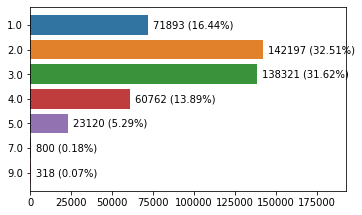

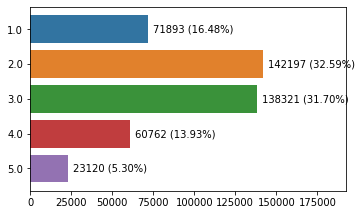

In [49]:
# GENHLTH
df = clean_and_report(
    df, 'GENHLTH', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='General Health Level'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Don't know / Not sure -> Missing
[3] 99 Refused -> Missing
There are 8964 (2.05%) missing records.


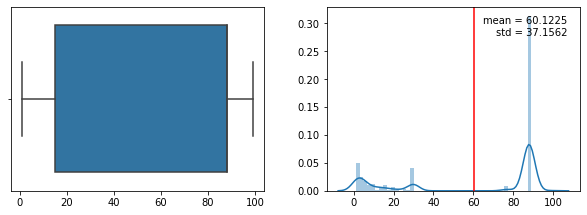

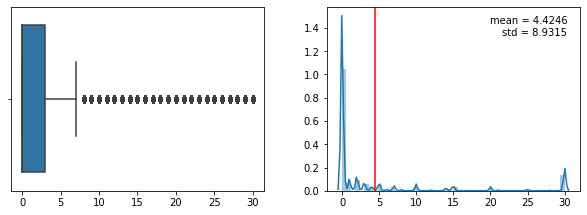

In [50]:
# PHYSHLTH
df = clean_and_report(
    df, 'PHYSHLTH', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], col_type='Continuous', var_description='Number of days physical health not good in the past month'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Don't know / Not sure -> Missing
[3] 99 Refused -> Missing
There are 7013 (1.60%) missing records.


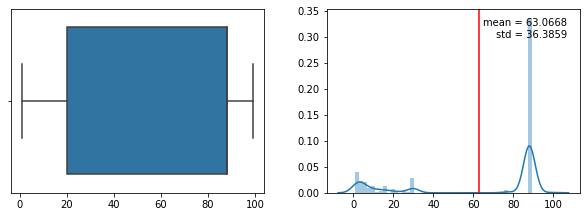

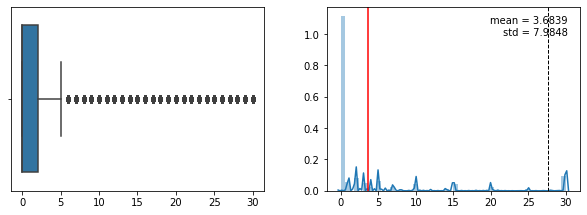

In [51]:
# MENTHLTH
df = clean_and_report(
    df, 'MENTHLTH', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], col_type='Continuous', var_description='Number of days mental health not good in the past month'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Don't know / Not sure -> Missing
[3] 99 Refused -> Missing
There are 210280 (48.07%) missing records.


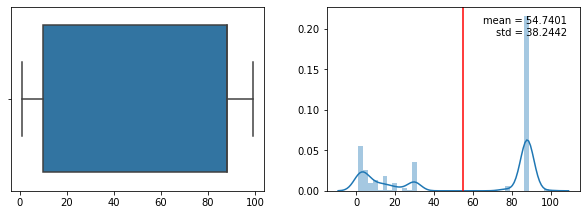

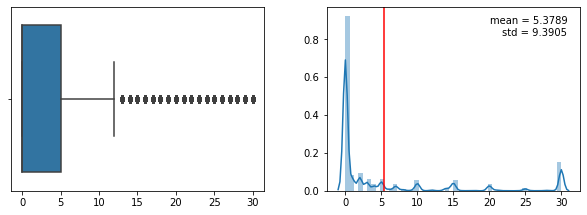

In [52]:
# POORHLTH
df = clean_and_report(
    df, 'POORHLTH', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], col_type='Continuous', 
    var_description='Number of days with poor physical or mental Health in the past month'
)

Cleaning Steps:
[1] 9 Don’t know/Not Sure Or Refused/Missing -> NA
There are 3298 (0.75%) missing records.


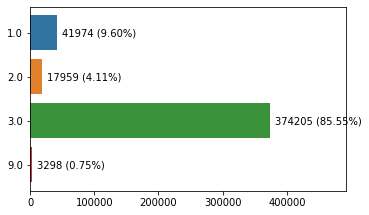

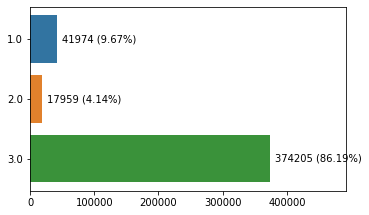

In [53]:
# Cleaning _ASTHMS1 - Computed asthma status
clean_steps_ASTHMS1 = [
    (lambda x: x == 9, lambda x: np.nan, "9 Don’t know/Not Sure Or Refused/Missing -> NA")
]
df = clean_and_report(
    df, '_ASTHMS1', clean_steps_ASTHMS1, var_description='Computed asthma status'
)

Cleaning Steps:
[1] 2 Not diagnosed with arthritis -> 0
There are 2534 (0.58%) missing records.


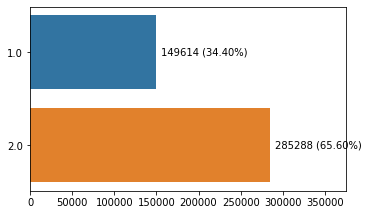

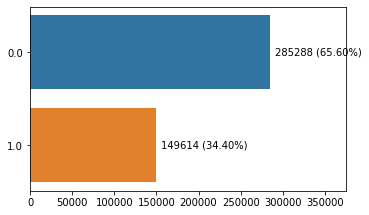

In [54]:
# Cleaning _DRDXAR1 - Respondents who have had a doctor diagnose them as having some form of arthritis
clean_steps_DRDXAR1 = [
    (lambda x: x == 2, lambda x: 0, "2 Not diagnosed with arthritis -> 0"),
]
df = clean_and_report(
    df, '_DRDXAR1', clean_steps_DRDXAR1,
    var_description='Respondents diagnosed with arthritis'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 1327 (0.30%) missing records.


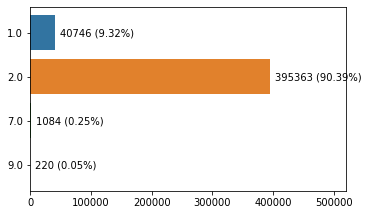

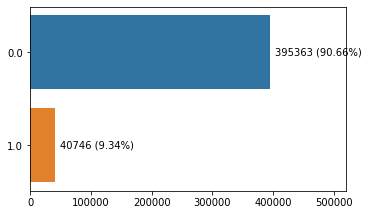

In [55]:
# CHCSCNCR
df = clean_and_report(
    df, 'CHCSCNCR', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='(Ever told) you had skin cancer?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 1238 (0.28%) missing records.


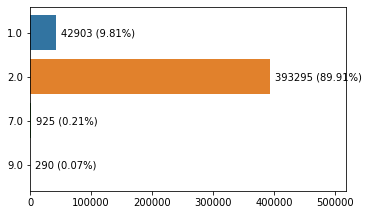

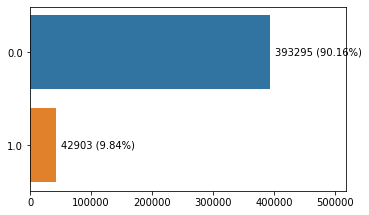

In [56]:
# CHCOCNCR
df = clean_and_report(
    df, 'CHCOCNCR', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='(Ever told) you had any other (than skin cancer) types of cancer?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 2201 (0.50%) missing records.


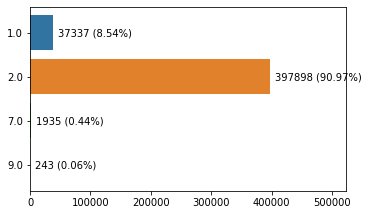

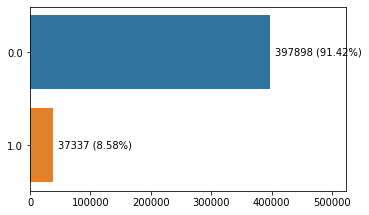

In [57]:
# CHCCOPD1
df = clean_and_report(
    df, 'CHCCOPD1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='(Ever told) you have chronic obstructive pulmonary disease, emphysema or chronic bronchitis?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 2534 (0.58%) missing records.


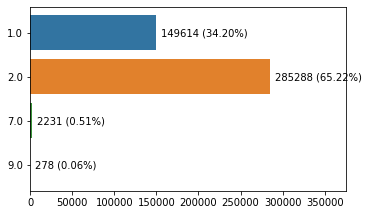

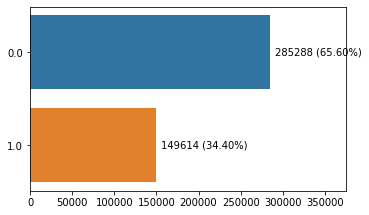

In [58]:
# HAVARTH3
df = clean_and_report(
    df, 'HAVARTH3', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='(Ever told) you have some form of arthritis, rheumatoid arthritis, gout, lupus, or fibromyalgia?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 2153 (0.49%) missing records.


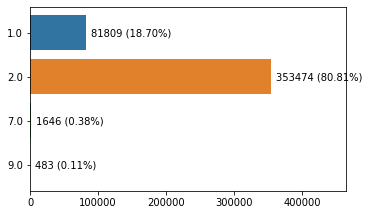

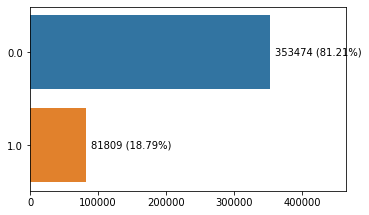

In [59]:
# ADDEPEV2
df = clean_and_report(
    df, 'ADDEPEV2', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Ever told you had a depressive disorder?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 1686 (0.39%) missing records.


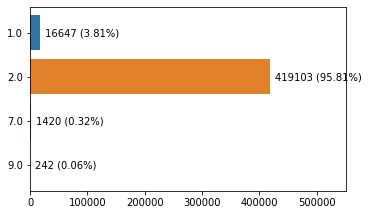

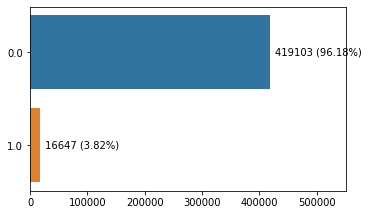

In [60]:
# CHCKDNY1
df = clean_and_report(
    df, 'CHCKDNY1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='(Ever told) you have kidney disease?'
)

Cleaning Steps:
[1] Convert from 0.01 kg to kg
There are 28572 (6.53%) missing records.


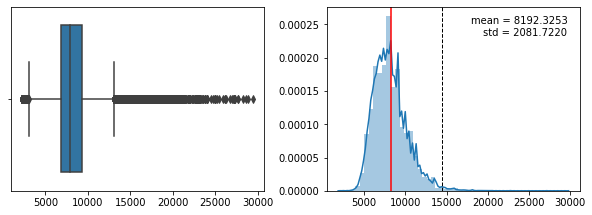

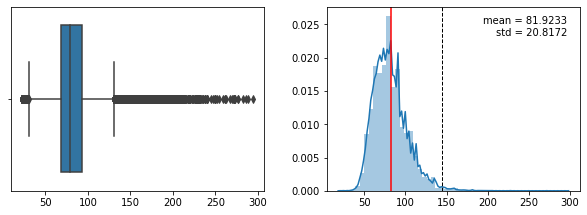

In [61]:
# For weight, only use WTKG3 (Computed Weight in Kilograms)
df = clean_and_report(
    df, 'WTKG3', [
        (lambda x: ~x.isna(), lambda x: x / 100, 'Convert from 0.01 kg to kg')
    ], var_description='Reported weight in kilograms'
)

Cleaning Steps:
[1] Convert from cm to m
There are 16462 (3.76%) missing records.


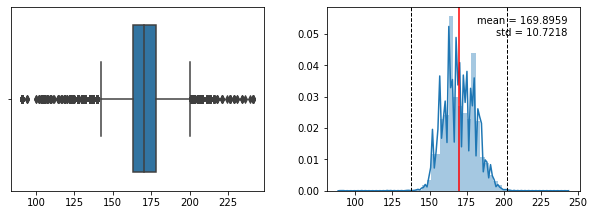

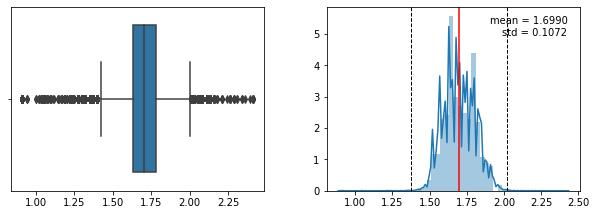

In [62]:
# For height, only use HTM4 (Computed Height in Meters)
df = clean_and_report(
    df, 'HTM4', [
        (lambda x: ~x.isna(), lambda x: x / 100, 'Convert from cm to m')
    ], var_description='Reported height in meters'
)

Cleaning Steps:
[1] Original data has two implied decimal places.
There are 35262 (8.06%) missing records.


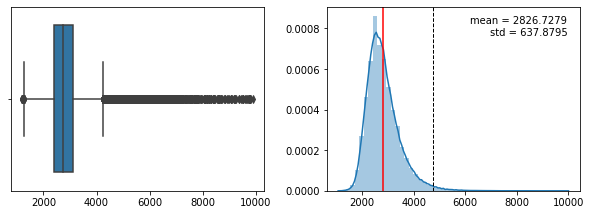

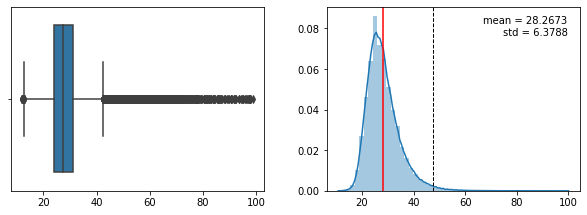

In [63]:
# _BMI5, Computed body mass index
df = clean_and_report(
    df, '_BMI5', [
        (lambda x: x.notna(), lambda x: x / 100, 'Original data has two implied decimal places.')
    ], var_description='Body Mass Index (BMI)'
)

There are 35262 (8.06%) missing records.


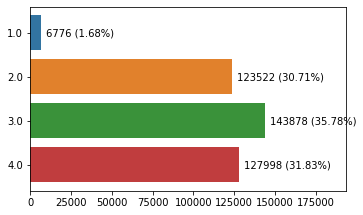

In [64]:
# _BMI5CAT, Four-categories of Body Mass Index (BMI)
df = clean_and_report(df, '_BMI5CAT', [], var_description='Four-categories of Body Mass Index (BMI)')

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 359923 (82.28%) missing records.


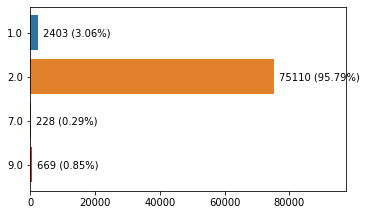

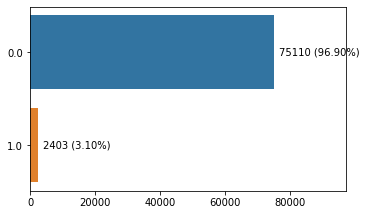

In [65]:
# PREGNANT
df = clean_and_report(
    df, 'PREGNANT', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Pregnancy Status'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 10630 (2.43%) missing records.


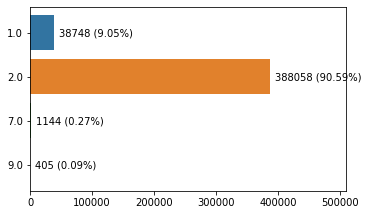

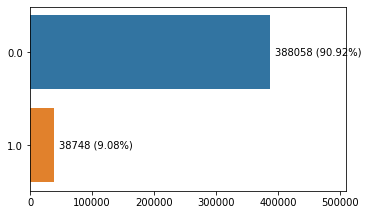

In [66]:
# DEAF
df = clean_and_report(
    df, 'DEAF', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Are you deaf or do you have serious difficulty hearing?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 11134 (2.55%) missing records.


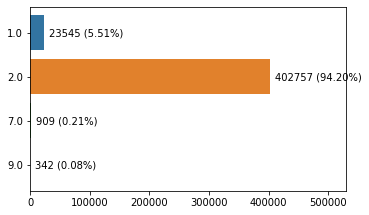

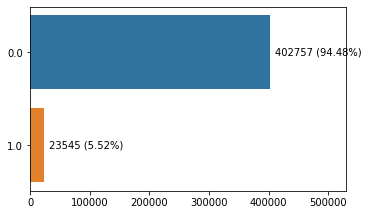

In [67]:
# BLIND
df = clean_and_report(
    df, 'BLIND', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Blind or Difficulty seeing'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 13500 (3.09%) missing records.


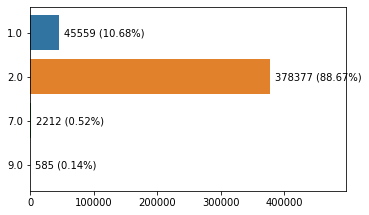

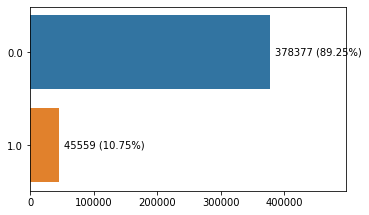

In [68]:
# DECIDE
df = clean_and_report(
    df, 'DECIDE', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Difficulty Concentrating or Remembering'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 13048 (2.98%) missing records.


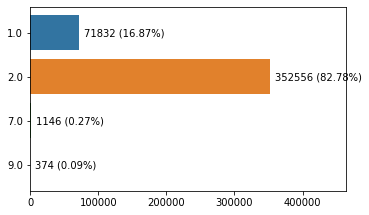

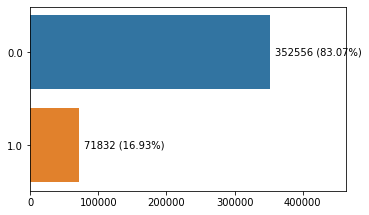

In [69]:
# DIFFWALK
df = clean_and_report(
    df, 'DIFFWALK', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Difficulty Walking or Climbing Stairs'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 12830 (2.93%) missing records.


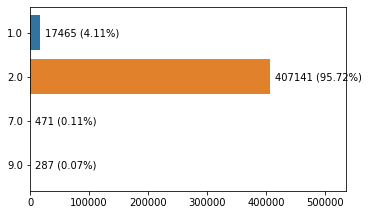

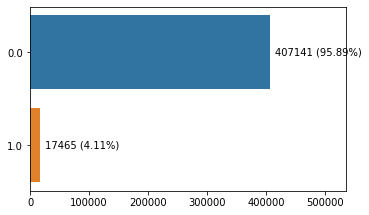

In [70]:
# DIFFDRES
df = clean_and_report(
    df, 'DIFFDRES', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Difficulty Dressing or Bathing'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 14220 (3.25%) missing records.


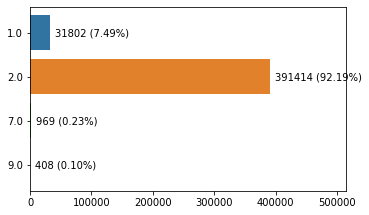

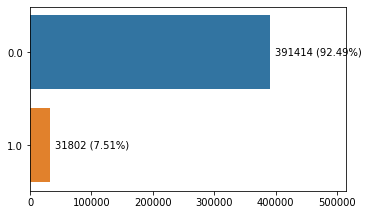

In [71]:
# DIFFALON
df = clean_and_report(
    df, 'DIFFALON', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Difficulty Doing Errands Alone'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 356715 (81.55%) missing records.


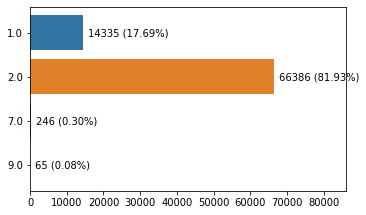

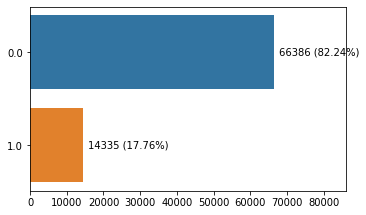

In [72]:
# COPDCOGH
df = clean_and_report(
    df, 'COPDCOGH', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='During the past 3 months, did you have a cough on most days?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 356092 (81.40%) missing records.


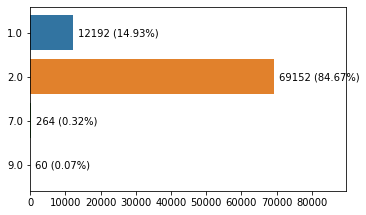

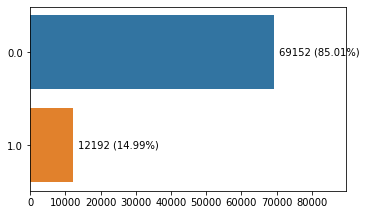

In [73]:
# COPDFLEM
df = clean_and_report(
    df, 'COPDFLEM', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='During the past 3 months, did you cough up phlegm or mucus on most days?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 356237 (81.44%) missing records.


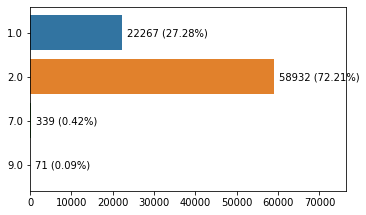

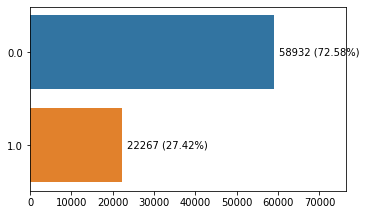

In [74]:
# COPDBRTH
df = clean_and_report(
    df, 'COPDBRTH', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do you have shortness of breath?'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Dont know / Not sure -> NA
[3] 99 Refused -> NA
There are 141534 (32.36%) missing records.


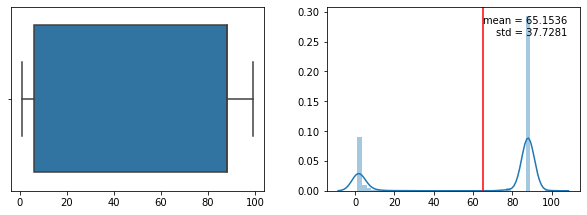

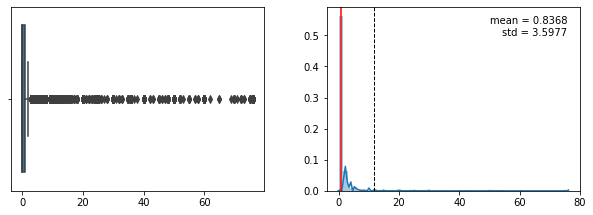

In [75]:
# FALL12MN
df = clean_and_report(
    df, 'FALL12MN', [
        (lambda x: x == 88, lambda x: 0, '88 None -> 0'),
        (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
        (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
    ], var_description='In the past 12 months, how many times have you fallen?'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Dont know / Not sure -> NA
[3] 99 Refused -> NA
There are 357660 (81.76%) missing records.


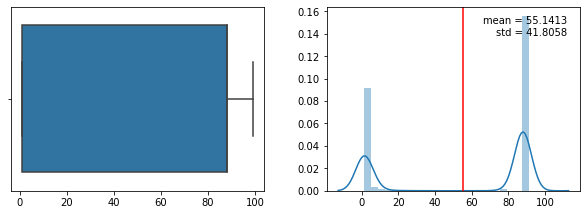

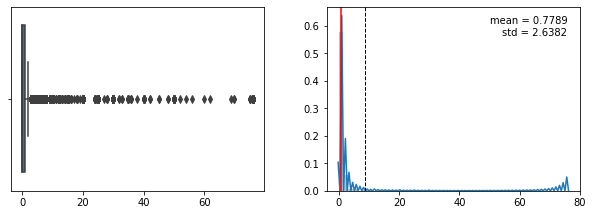

In [76]:
# FALLINJ3
df = clean_and_report(
    df, 'FALLINJ3', [
        (lambda x: x == 88, lambda x: 0, '88 None -> 0'),
        (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
        (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
    ], var_description='How many of these falls caused an injury that limited your regular activities for at least a day?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 428986 (98.07%) missing records.


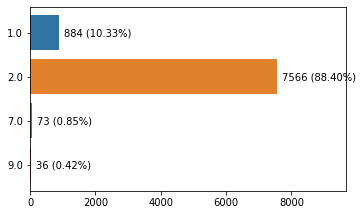

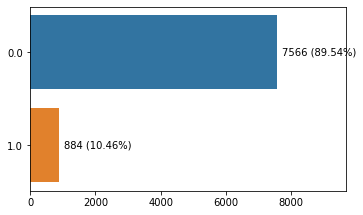

In [77]:
# CIMEMLOS
df = clean_and_report(
    df, 'CIMEMLOS', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ],
    var_description='During the past 12 months, have you experienced confusion or memory loss that is happening more often or is getting worse?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 436495 (99.78%) missing records.


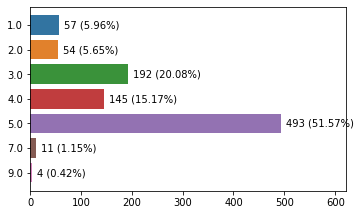

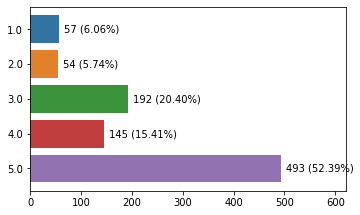

In [78]:
# CDHOUSE
df = clean_and_report(
    df, 'CDHOUSE', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='During the past 12 months, as a result of confusion or memory loss, how often have you given up day-to-day household activities you used to do?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 436494 (99.78%) missing records.


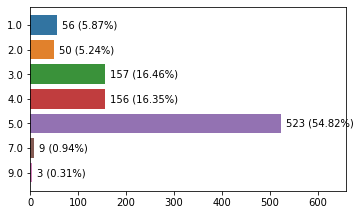

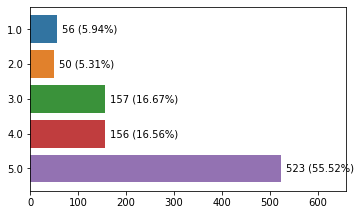

In [79]:
# CDASSIST
df = clean_and_report(
    df, 'CDASSIST', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Need assistance with day-to-day activities due to confusion or memory loss'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
There are 437175 (99.94%) missing records.


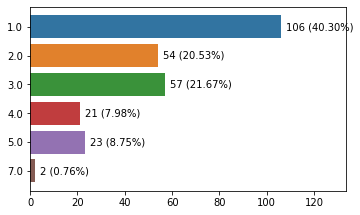

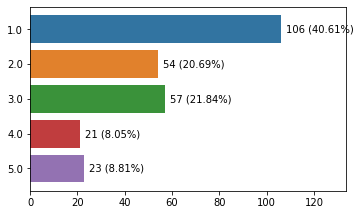

In [80]:
# CDHELP
df = clean_and_report(
    df, 'CDHELP', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing")
    ], var_description='When you need help with day-to-day activities are you able to get it?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 436499 (99.79%) missing records.


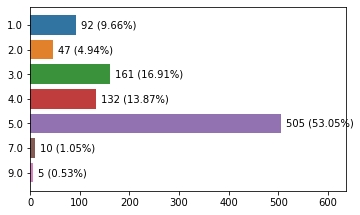

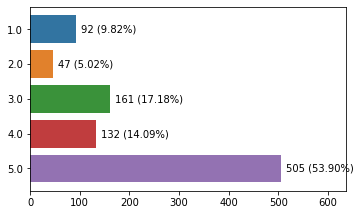

In [81]:
# CDSOCIAL
df = clean_and_report(
    df, 'CDSOCIAL', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Does confusion or memory loss interfere with work or social activities?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 436496 (99.79%) missing records.


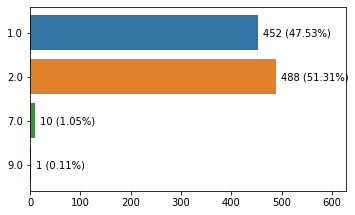

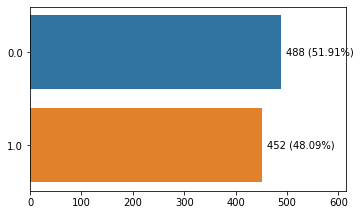

In [82]:
# CDDISCUS
df = clean_and_report(
    df, 'CDDISCUS', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have you discussed your confusion or memory loss with a health care professional?'
)

## Smoking

In [83]:
# Drop _RFSMOK3 - Current Smoking Calculated Variable (Reduandant of _SMOKER3)
df = df.drop(columns=['_RFSMOK3'])

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 16406 (3.75%) missing records.


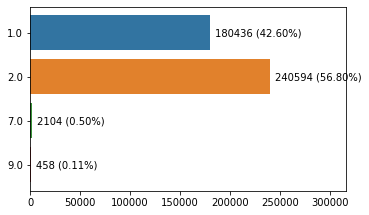

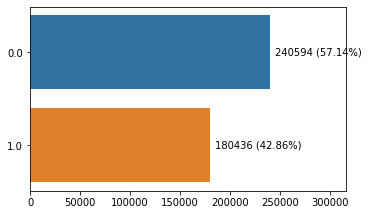

In [84]:
# SMOKE100
df = clean_and_report(
    df, 'SMOKE100', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Smoked at Least 100 Cigarettes'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 257410 (58.85%) missing records.


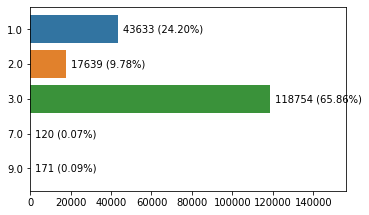

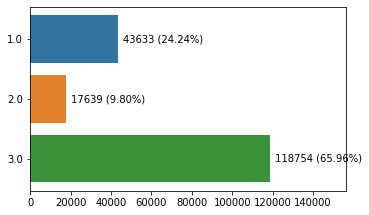

In [85]:
# SMOKDAY2
df = clean_and_report(
    df, 'SMOKDAY2', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do you now smoke cigarettes every day, some days, or not at all?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 376440 (86.06%) missing records.


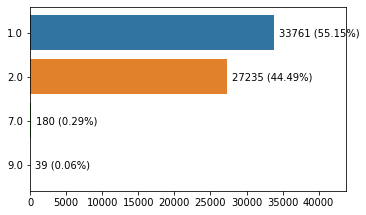

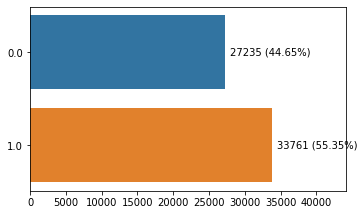

In [86]:
# STOPSMK2
df = clean_and_report(
    df, 'STOPSMK2', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Stopped Smoking in past 12 months'
)

Cleaning Steps:
[1] 77 Don't know / Not sure -> Missing
[2] 99 Refused -> Missing
There are 319654 (73.07%) missing records.


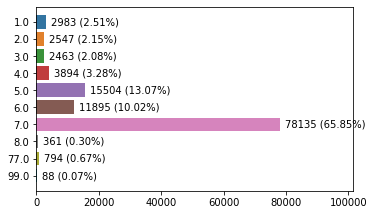

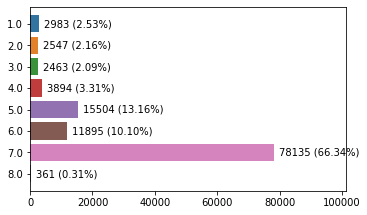

In [87]:
# LASTSMK2
df = clean_and_report(
    df, 'LASTSMK2', 
    [
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], var_description='Interval Since Last Smoked'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 15146 (3.46%) missing records.


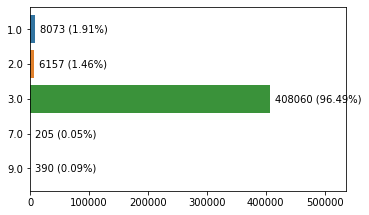

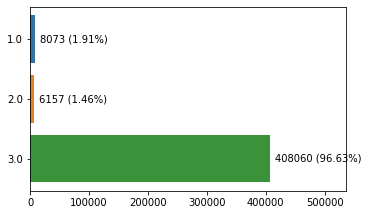

In [88]:
# USENOW3
df = clean_and_report(
    df, 'USENOW3', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Frequency of Use of Smokeless Tobacco Products'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Don't know / Not sure -> Missing
[3] 99 Refused -> Missing
There are 358061 (81.85%) missing records.


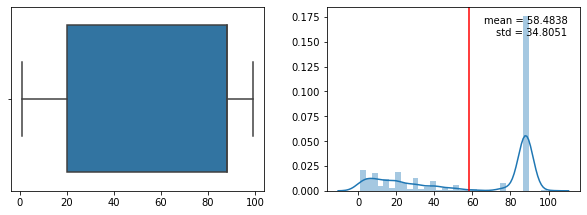

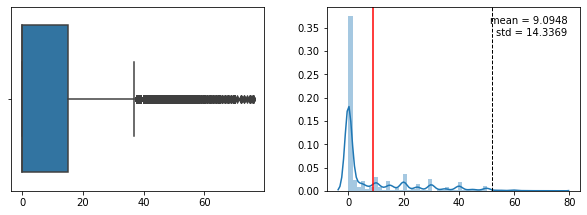

In [89]:
# COPDSMOK
df = clean_and_report(
    df, 'COPDSMOK', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], col_type='Continuous',
    var_description='How many years have you smoked tobacco products?'
)

Cleaning Steps:
[1] 777 Dont know / Not sure -> NA
[2] 999 Refused -> NA
[3] Age value out of range 1 - 100 -> NA
There are 420345 (96.09%) missing records.


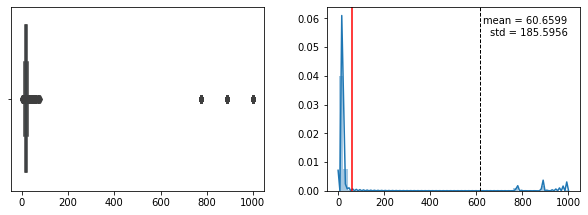

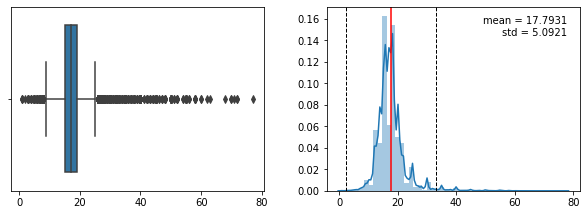

In [90]:
# Cleaning LCSFIRST - How old when you first started smoking?
clean_steps_LCSFIRST = [
    (lambda x: x == 777, lambda x: np.nan, '777 Dont know / Not sure -> NA'),
    (lambda x: x == 999, lambda x: np.nan, '999 Refused -> NA'),
    (lambda x: (x < 1) | (x > 100), lambda x: np.nan, 'Age value out of range 1 - 100 -> NA')
]
df = clean_and_report(
    df, 'LCSFIRST', clean_steps_LCSFIRST,
    var_description='How old when you first started smoking?'
)

Cleaning Steps:
[1] 777 Dont know / Not sure -> NA
[2] 999 Refused -> NA
[3] Age value out of range 1 - 100 -> NA
There are 420431 (96.11%) missing records.


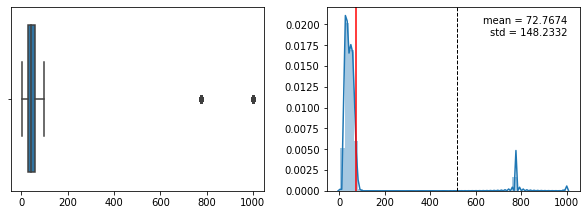

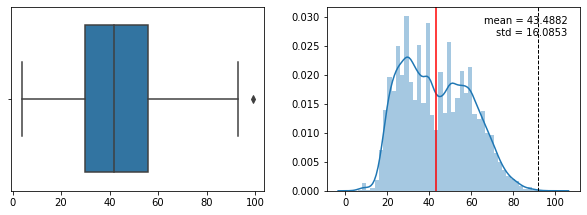

In [91]:
# Cleaning LCSLAST - How old were you when you last smoked cigarettes regularly?
clean_steps_LCSLAST = [
    (lambda x: x == 777, lambda x: np.nan, '777 Dont know / Not sure -> NA'),
    (lambda x: x == 999, lambda x: np.nan, '999 Refused -> NA'),
    (lambda x: (x < 1) | (x > 100), lambda x: np.nan, 'Age value out of range 1 - 100 -> NA')
]
df = clean_and_report(
    df, 'LCSLAST', clean_steps_LCSLAST,
    var_description='How old when you last smoked?'
)

Cleaning Steps:
[1] 777 Dont know / Not sure -> NA
[2] 999 Refused -> NA
There are 420594 (96.15%) missing records.


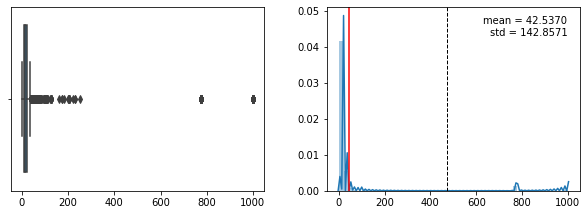

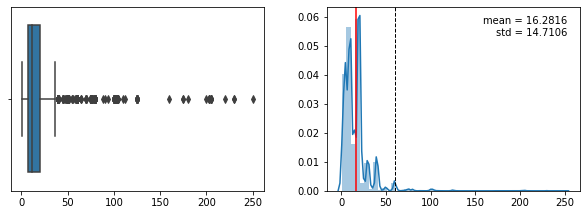

In [92]:
# Cleaning LCSNUMCG - On Average, how many cigarettes do you smoke each day?
clean_steps_LCSNUMCG = [
    (lambda x: x == 777, lambda x: np.nan, '777 Dont know / Not sure -> NA'),
    (lambda x: x == 999, lambda x: np.nan, '999 Refused -> NA'),
]
df = clean_and_report(
    df, 'LCSNUMCG', clean_steps_LCSNUMCG,
    var_description='Averagely how many cigarettes do you smoke each day?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 177112 (40.49%) missing records.


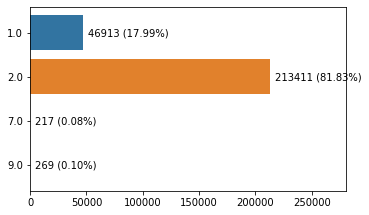

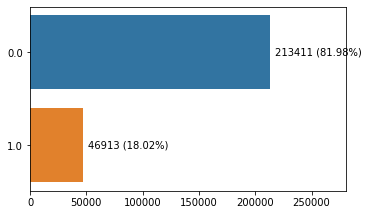

In [93]:
# ECIGARET
df = clean_and_report(
    df, 'ECIGARET', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Ever used an e-cigarette?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 390651 (89.30%) missing records.


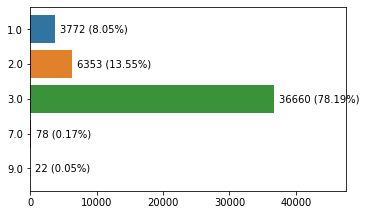

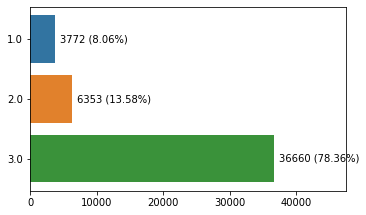

In [94]:
# ECIGNOW
df = clean_and_report(
    df, 'ECIGNOW', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do you now use e-cigarettes, every day, some days, or not at all?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 429624 (98.21%) missing records.


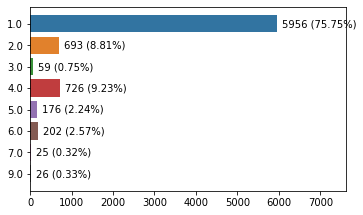

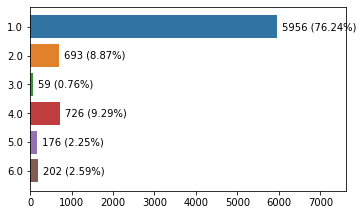

In [95]:
# USEMRJN2
df = clean_and_report(
    df, 'USEMRJN2', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='During the past 30 days, how did you primarily use marijuana?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 429644 (98.22%) missing records.


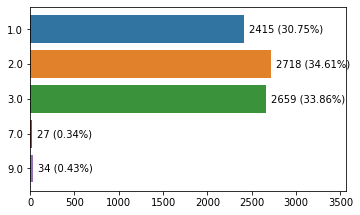

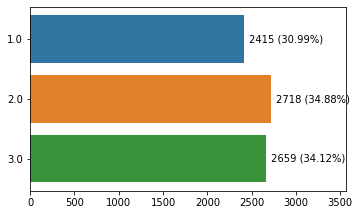

In [96]:
# RSNMRJN1
df = clean_and_report(
    df, 'RSNMRJN1', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='What was the reason you used marijuana?'
)

Cleaning Steps:
[1] 9 Refused, do not know or missing ->NA
There are 16816 (3.84%) missing records.


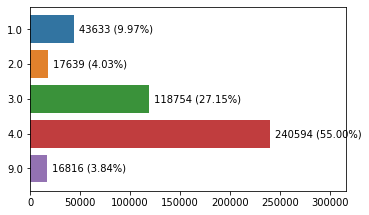

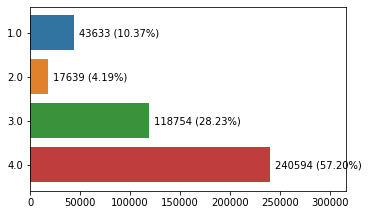

In [97]:
# _SMOKER3
clean_steps_SMOKER3 = [
    (lambda x: x == 9, lambda x: np.nan, '9 Refused, do not know or missing ->NA'),
]
df = clean_and_report(
    df, '_SMOKER3', clean_steps_SMOKER3,
    var_description='Four-level smoker status: Everyday smoker, Someday smoker, Former smoker, Non-smoker'
)

## Alcohol Consumption

In [98]:
# Variables to drop
# DRNKANY5 - Drink any alcoholic beverages in past 30 days (binary version of ALCDAY5)
# DROCDY3_ - Computed drink-occasions-per-day (computed version of ALCDAY5)
df = df.drop(columns=['DRNKANY5', 'DROCDY3_'])

Cleaning Steps:
[1] 1XX means XX days per week. Convert to per month. -> (x - 100) / 7 * 30
[2] 2XX means XX days per month. -> (x - 200)
[3] 777 Dont know / Not sure -> NA
[4] 888 No drinks -> 0
[5] 999 Refused -> NA
There are 21746 (4.97%) missing records.


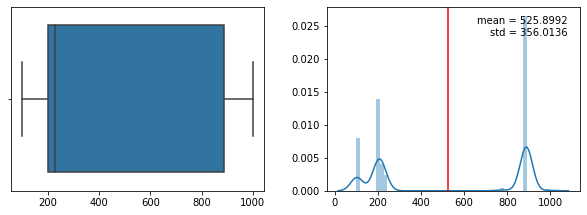

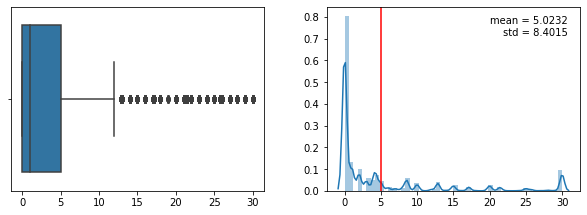

In [99]:
# ALCDAY5
df = clean_and_report(
    df, 'ALCDAY5', 
    [
        (
            lambda x: (x >= 101) & (x <= 107),
            lambda x: (x - 100) / 7 * 30, 
            '1XX means XX days per week. Convert to per month. -> (x - 100) / 7 * 30'
        ),
        (
            lambda x: (x >= 201) & (x <= 230),
            lambda x: (x - 200),
            '2XX means XX days per month. -> (x - 200)'
        ),
        (lambda x: x == 777, lambda x: np.nan, '777 Dont know / Not sure -> NA'),
        (lambda x: x == 888, lambda x: 0, '888 No drinks -> 0'),
        (lambda x: x == 999, lambda x: np.nan, '999 Refused -> NA'),
    ], col_type='Continuous', var_description='Days in past 30 had alcoholic beverage'
)

Cleaning Steps:
[1] 77 Dont know / Not sure -> NA
[2] 99 Refused -> NA
[3] Clip outliers out of 1.5 IQR
There are 227690 (52.05%) missing records.


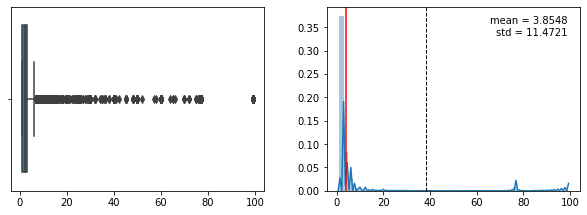

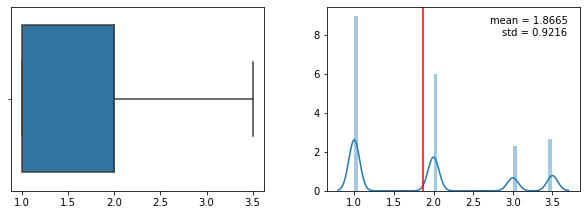

In [100]:
# AVEDRNK2
df = clean_and_report(
    df, 'AVEDRNK2', [
        (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
        (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
        (lambda x: ~x.isna(), iqr_outlier_clipper, 'Clip outliers out of 1.5 IQR')
    ], var_description='Avg alcoholic drinks per day in past 30 days'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Dont know / Not sure -> NA
[3] 99 Refused -> NA
[4] Clip outliers out of 1.5 IQR
There are 226966 (51.89%) missing records.


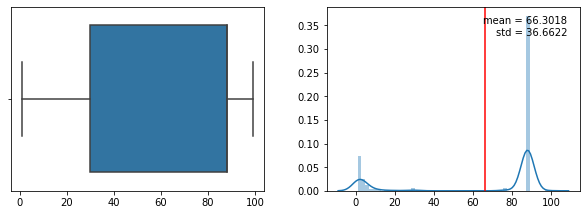

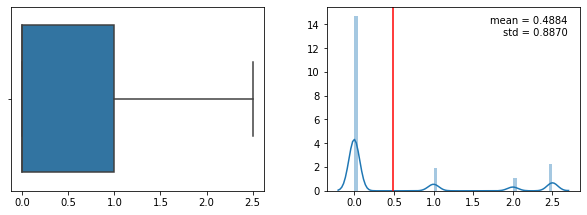

In [101]:
# DRNK3GE5
df = clean_and_report(
    df, 'DRNK3GE5', [
        (lambda x: x == 88, lambda x: 0, '88 None -> 0'),
        (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
        (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
        (lambda x: ~x.isna(), iqr_outlier_clipper, 'Clip outliers out of 1.5 IQR')
    ],
    var_description='How many times during the past 30 days did you have 5 or more drinks for men or 4 or more drinks for women on an occasion?'
)

Cleaning Steps:
[1] 77 Dont know / Not sure -> NA
[2] 99 Refused -> NA
[3] Clip outliers out of 1.5 IQR
There are 231809 (52.99%) missing records.


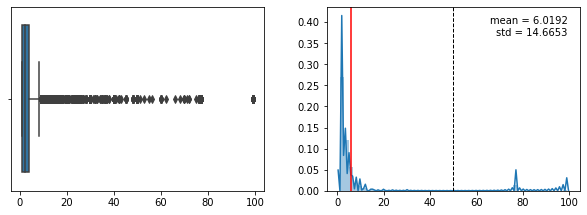

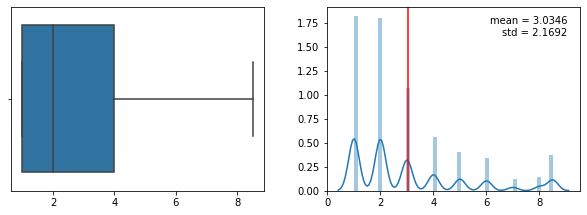

In [102]:
# MAXDRNKS
df = clean_and_report(
    df, 'MAXDRNKS', [
        (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
        (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
        (lambda x: ~x.isna(), iqr_outlier_clipper, 'Clip outliers out of 1.5 IQR')
    ], var_description='Most drinks on single occasion past 30 days'
)

Cleaning Steps:
[1] 9 Refused, do not know or missing -> NA
[2] 1 No, 2 Yes -> 0 No, 1 Yes
There are 25953 (5.93%) missing records.


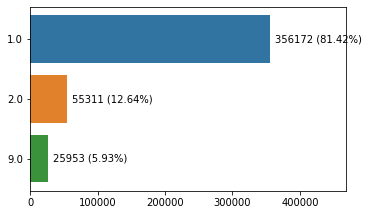

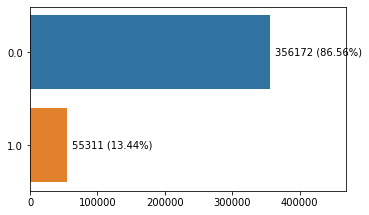

In [103]:
# _RFBING5 Binge drinkers
clean_steps_RFBING5 = [
    (lambda x: x == 9, lambda x: np.nan, '9 Refused, do not know or missing -> NA'),
    (lambda x: (x == 1) | (x == 2), lambda x: x - 1, '1 No, 2 Yes -> 0 No, 1 Yes')
]
df = clean_and_report(df, '_RFBING5', clean_steps_RFBING5, var_description='Binge drinkers')


Cleaning Steps:
[1] 99900 Refused, do not know or missing -> NA
[2] Clip outliers out of 1.5 IQR
There are 26678 (6.10%) missing records.


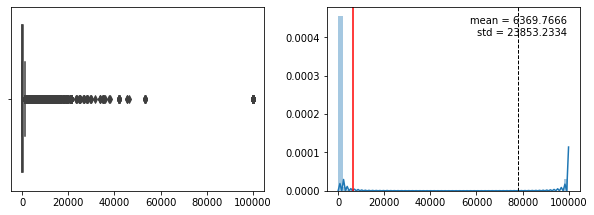

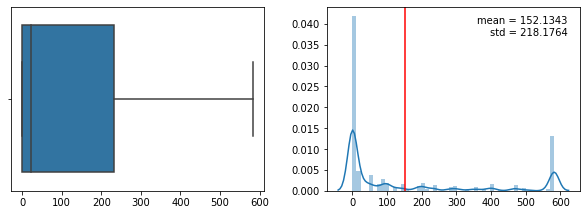

In [104]:
# _DRNKWEK, Computed number of drinks of alcohol beverages per week
clean_steps_DRNKWEK = [
    (lambda x: x == 99900, lambda x: np.nan, '99900 Refused, do not know or missing -> NA'),
    (lambda x: ~x.isna(), iqr_outlier_clipper, 'Clip outliers out of 1.5 IQR')
]
df = clean_and_report(
    df, '_DRNKWEK', clean_steps_DRNKWEK, 
    col_type = 'Continuous', var_description='Computed number of drinks of alcohol beverages per week'
)


Cleaning Steps:
[1] 9 Refused, do not know or missing ->NA
[2] 1 No, 2 Yes -> 0 No, 1 Yes
There are 27013 (6.18%) missing records.


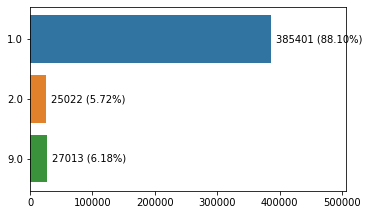

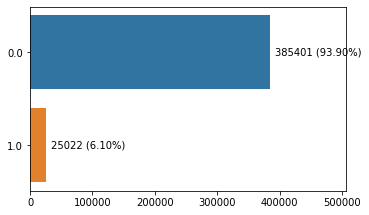

In [105]:
# _RFDRHV6, Heavy drinkers
clean_steps_RFDRHV6 = [
    (lambda x: x == 9, lambda x: np.nan, '9 Refused, do not know or missing ->NA'),
    (lambda x: (x == 1) | (x == 2), lambda x: x - 1, '1 No, 2 Yes -> 0 No, 1 Yes')
]
df = clean_and_report(df, '_RFDRHV6', clean_steps_RFDRHV6, var_description='Heavy drinkers')


## Sleep

Cleaning Steps:
[1] 77 Don't know / Not sure -> Missing
[2] 99 Refused -> Missing
There are 5337 (1.22%) missing records.


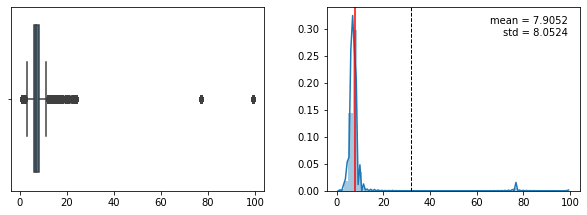

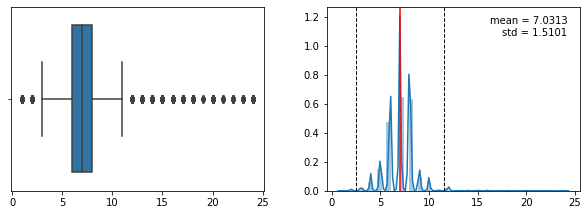

In [106]:
# SLEPTIM1
df = clean_and_report(
    df, 'SLEPTIM1', 
    [
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], col_type='Continuous',
    var_description='On average, how many hours of sleep do you get in a 24-hour period?'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Don't know / Not sure -> Missing
[3] 99 Refused -> Missing
There are 433186 (99.03%) missing records.


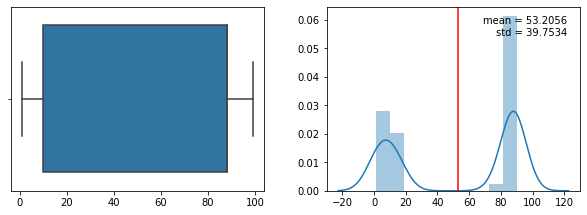

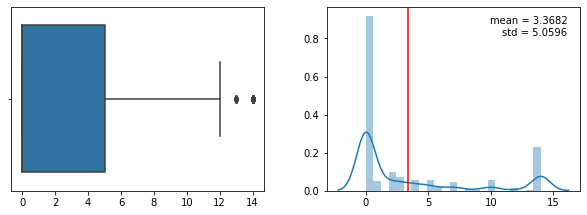

In [107]:
# ADSLEEP
df = clean_and_report(
    df, 'ADSLEEP', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], col_type='Continuous', var_description='Days had trouble with sleep over the last 2 weeks'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Don't know / Not sure -> Missing
[3] 99 Refused -> Missing
There are 433194 (99.03%) missing records.


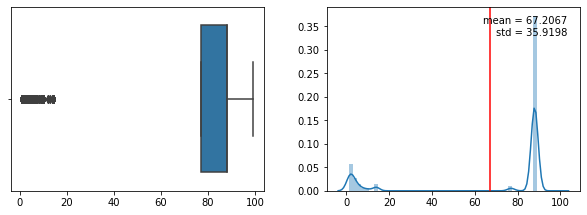

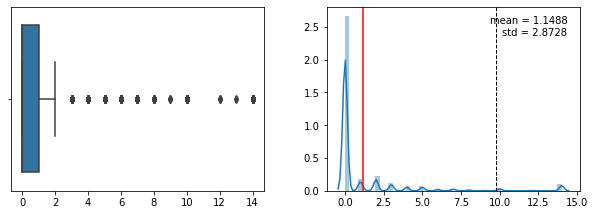

In [108]:
# SLEPDAY1
df = clean_and_report(
    df, 'SLEPDAY1', 
    [
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], col_type='Continuous',
    var_description='Over the last 2 weeks, how many days did you unintentionally fall asleep during the day?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
There are 433134 (99.02%) missing records.


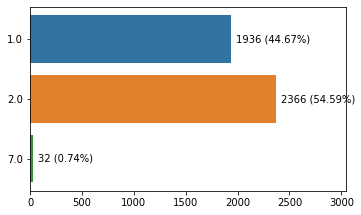

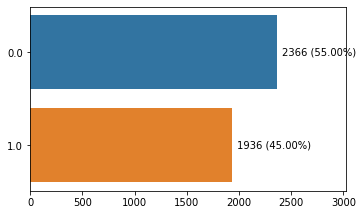

In [109]:
# SLEPSNO2
df = clean_and_report(
    df, 'SLEPSNO2', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing")
    ], var_description='Have you ever been told that you snore loudly?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 433139 (99.02%) missing records.


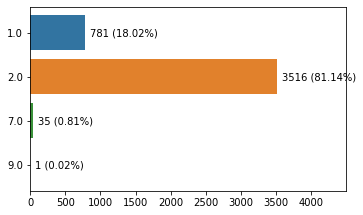

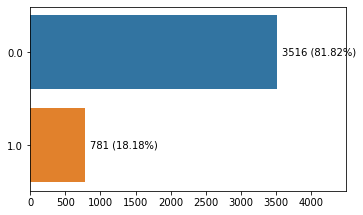

In [110]:
# SLEPBRTH
df = clean_and_report(
    df, 'SLEPBRTH', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], 'Has anyone ever observed that you stop breathing during your sleep?'
)

## Exercise

In [111]:
# Drop _TOTINDA - redundant of EXERANY2
df = df.drop(columns=['_TOTINDA'])

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 695 (0.16%) missing records.


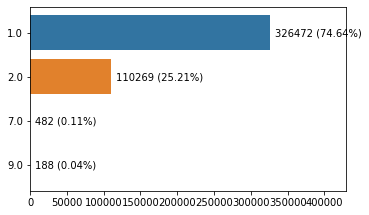

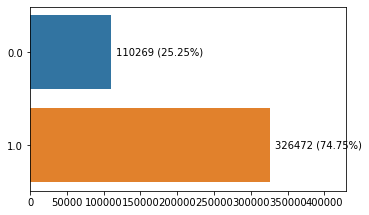

In [112]:
# EXERANY2
df = clean_and_report(
    df, 'EXERANY2', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Exercise in Past 30 Days'
)

## Drive

In [113]:
# Variables to drop
# _RFSEAT2 - binned version of SEATBELT
# _RFSEAT3 - binned version of SEATBELT
# _DRNKDRV - binned version of DRNKDRI2
df = df.drop(columns=['_RFSEAT2', '_RFSEAT3', '_DRNKDRV'])

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 21407 (4.89%) missing records.


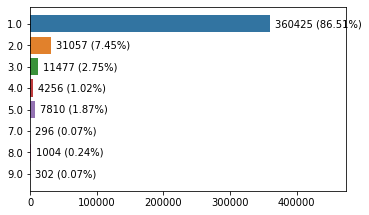

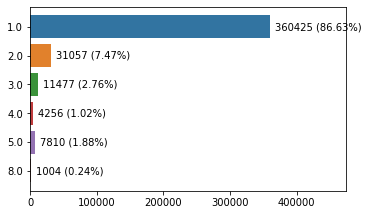

In [114]:
# SEATBELT
df = clean_and_report(
    df, 'SEATBELT', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='How often use seatbelts in car?'
)

Cleaning Steps:
[1] 88 None -> 0
[2] 77 Dont know / Not sure -> NA
[3] 99 Refused -> NA
There are 222132 (50.78%) missing records.


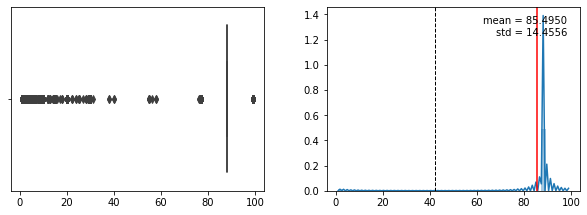

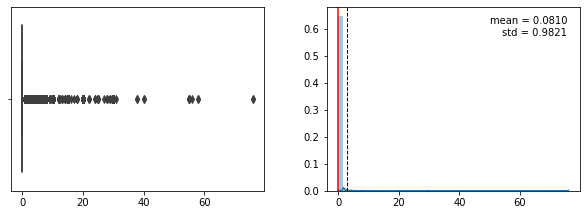

In [115]:
# DRNKDRI2
df = clean_and_report(
    df, 'DRNKDRI2', [
        (lambda x: x == 88, lambda x: 0, '88 None -> 0'),
        (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
        (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
    ], var_description='During the past 30 days, how many times have you driven when you’ve had perhaps too much to drink?'
)

## Sun Exposure

Cleaning Steps:
[1] 777 Don't know / Not sure -> Missing
[2] 999 Refused -> Missing
There are 432176 (98.80%) missing records.


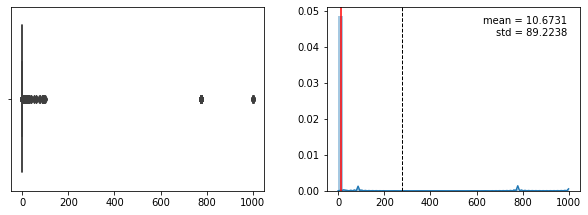

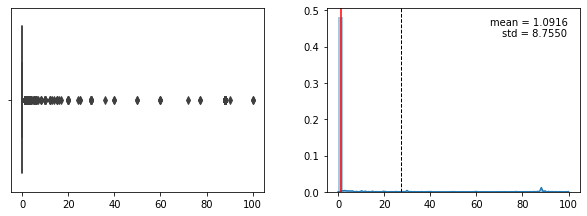

In [116]:
# INDORTAN
df = clean_and_report(
    df, 'INDORTAN', 
    [
        (lambda x: x == 777, lambda x: np.nan, "777 Don't know / Not sure -> Missing"),
        (lambda x: x == 999, lambda x: np.nan, "999 Refused -> Missing")
    ], col_type='Continuous', var_description='Times used an indoor tanning device in the past year'
)

Cleaning Steps:
[1] 777 Don't know / Not sure -> Missing
[2] 999 Refused -> Missing
There are 423517 (96.82%) missing records.


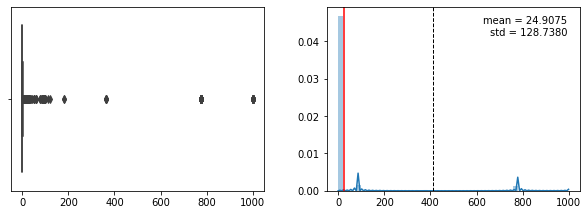

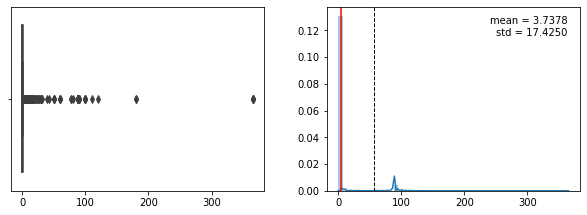

In [117]:
# NUMBURN3
df = clean_and_report(
    df, 'NUMBURN3', 
    [
        (lambda x: x == 777, lambda x: np.nan, "777 Don't know / Not sure -> Missing"),
        (lambda x: x == 999, lambda x: np.nan, "999 Refused -> Missing")
    ], col_type='Continuous', var_description='Number Of Sunburns In Past 12 Months'
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 425292 (97.22%) missing records.


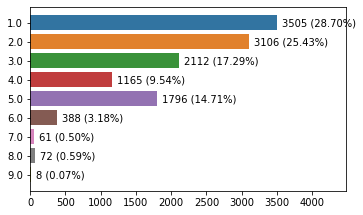

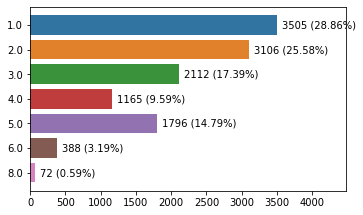

In [118]:
# Cleaning SUNPRTCT - How often protect yourself from the sun
clean_steps_SUNPRTCT = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'SUNPRTCT', clean_steps_SUNPRTCT, 
    var_description='How often protect yourself from the sun'
)

Cleaning Steps:
[1] 77 Dont know / Not sure -> NA
[2] 99 Refused -> NA
There are 424021 (96.93%) missing records.


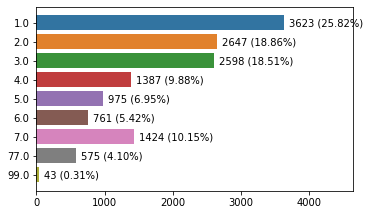

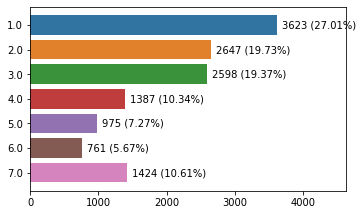

In [119]:
# Cleaning WKDAYOUT - On weekdays, in the summer, how long are you outside per day between 10am and 4pm
clean_steps_WKDAYOUT = [
    (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
    (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
]
df = clean_and_report(
    df, 'WKDAYOUT', clean_steps_WKDAYOUT, 
    var_description='On weekdays, in the summer, how long are you outside per day between 10am and 4pm?'
)

Cleaning Steps:
[1] 77 Dont know / Not sure -> NA
[2] 99 Refused -> NA
There are 424074 (96.95%) missing records.


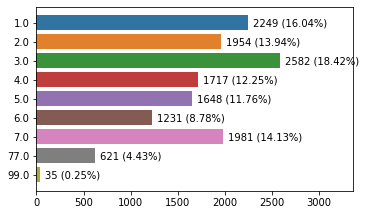

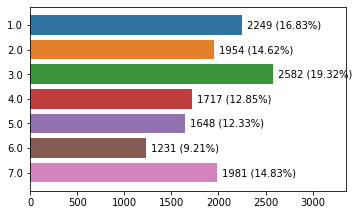

In [120]:
# Cleaning WKENDOUT - On weekends in the summer, how long are you outside each day between 10am and 4pm?
clean_steps_WKENDOUT = [
    (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
    (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
]
df = clean_and_report(
    df, 'WKENDOUT', clean_steps_WKENDOUT, 
    var_description='On weekends in the summer, how long are you outside each day between 10am and 4pm?'
)

## Healthcare Access

In [121]:
# Variables to drop
# _HCVU651 - Respondents aged 18-64 with health care coverage (Redudant)
# DLYOTHER - Delayed Getting Medical Care Other Response text entry
df = df.drop(columns=['_HCVU651', 'DLYOTHER'])

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 1974 (0.45%) missing records.


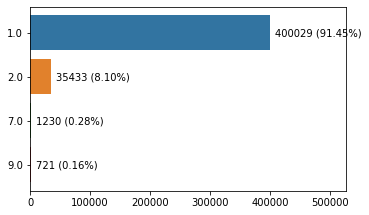

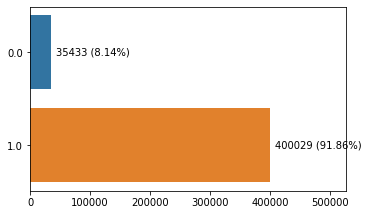

In [122]:
# HLTHPLN1
df = clean_and_report(
    df, 'HLTHPLN1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have any health care coverage'
)

Cleaning Steps:
[1] 3 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 2775 (0.63%) missing records.


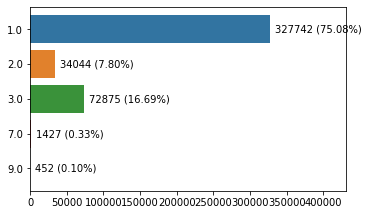

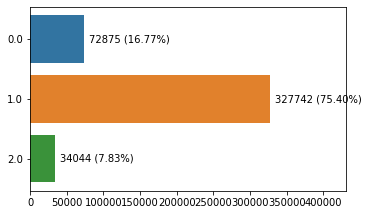

In [123]:
# PERSDOC2
df = clean_and_report(
    df, 'PERSDOC2', 
    [
        (lambda x: x == 3, lambda x: 0, "3 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do you have one person you think of as your personal doctor or health care provider?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 2124 (0.49%) missing records.


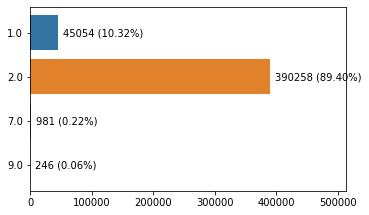

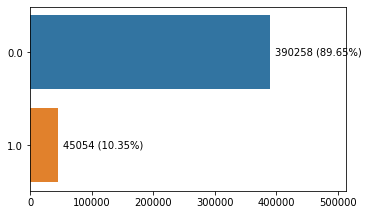

In [124]:
# MEDCOST
df = clean_and_report(
    df, 'MEDCOST', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Could Not See Doctor Because of Cost'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 387110 (88.50%) missing records.


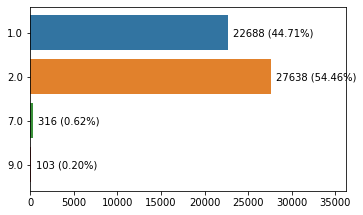

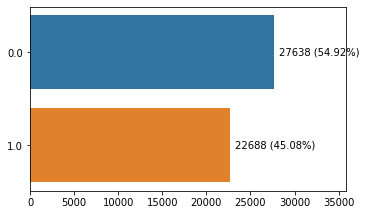

In [125]:
# MEDICARE
df = clean_and_report(
    df, 'MEDICARE', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do you have Medicare?'
)

Cleaning Steps:
[1] 77 Don't know / Not sure -> Missing
[2] 99 Refused -> Missing
There are 387638 (88.62%) missing records.


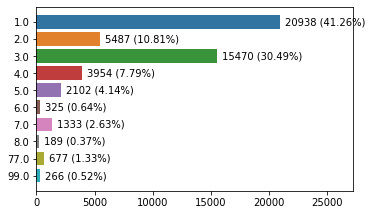

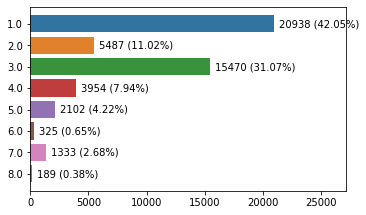

In [126]:
# HLTHCVR1
df = clean_and_report(
    df, 'HLTHCVR1', 
    [
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 99, lambda x: np.nan, "99 Refused -> Missing")
    ], var_description='What is the primary source of your health care coverage?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 381748 (87.27%) missing records.


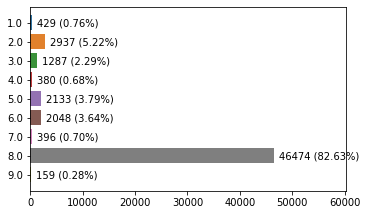

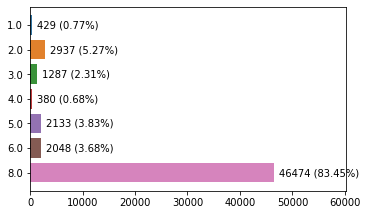

In [127]:
# DELAYME1
df = clean_and_report(
    df, 'DELAYME1', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Other than cost, have you delayed getting medical care for one of the following reasons in the past 12 months?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 386791 (88.42%) missing records.


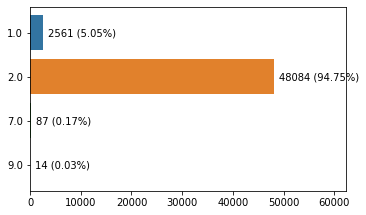

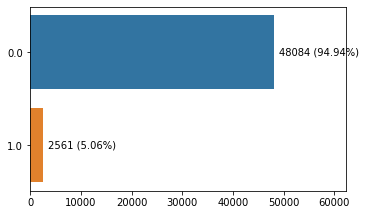

In [128]:
# NOCOV121
df = clean_and_report(
    df, 'NOCOV121', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='In the PAST 12 MONTHS was there any time when you did NOT have ANY health insurance or coverage?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 432580 (98.89%) missing records.


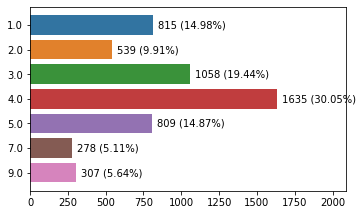

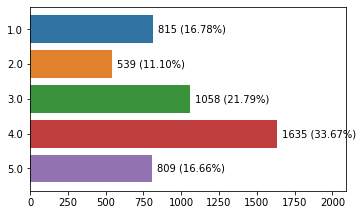

In [129]:
# LSTCOVRG
df = clean_and_report(
    df, 'LSTCOVRG', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Time Since Last Had Health Care Coverage'
)

Cleaning Steps:
[1] 77 Don't know / Not sure -> Missing
[2] 88 None -> 0
[3] Larger than 76, invalid value -> Missing
There are 383427 (87.65%) missing records.


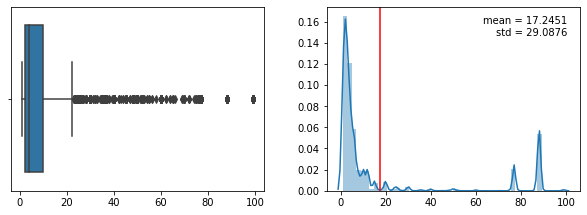

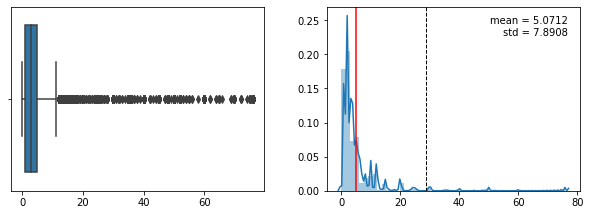

In [130]:
# DRVISITS
df = clean_and_report(
    df, 'DRVISITS', 
    [
        (lambda x: x == 77, lambda x: np.nan, "77 Don't know / Not sure -> Missing"),
        (lambda x: x == 88, lambda x: 0, "88 None -> 0"),
        (lambda x: x > 76, lambda x: np.nan, "Larger than 76, invalid value -> Missing")
    ],
    var_description='How many times have you been to a doctor, nurse, or other health professional in the past 12 months?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 3 No medication was prescribed, not applicable -> Missing
[3] 7 Don't know / Not sure -> Missing
[4] 9 Refused -> Missing
There are 386736 (88.41%) missing records.


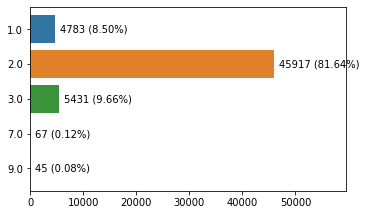

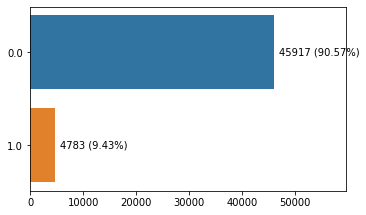

In [131]:
# MEDSCOS1
df = clean_and_report(
    df, 'MEDSCOS1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 3, lambda x: np.nan, "3 No medication was prescribed, not applicable -> Missing"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Could Not Get Medicine Due To Cost'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 8 Not applicable -> Missing
[3] 9 Refused -> Missing
There are 382757 (87.50%) missing records.


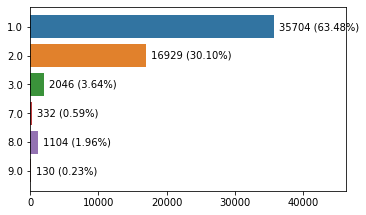

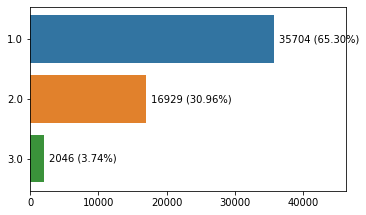

In [132]:
# CARERCVD
df = clean_and_report(
    df, 'CARERCVD', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 8, lambda x: np.nan, "8 Not applicable -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='In general, how satisfied are you with the health care you received?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 381645 (87.25%) missing records.


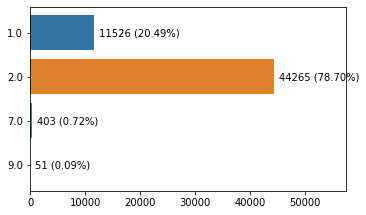

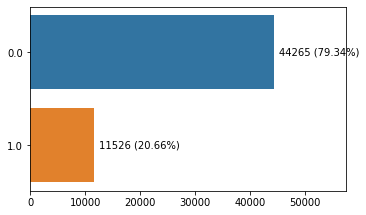

In [133]:
# MEDBILL1
df = clean_and_report(
    df, 'MEDBILL1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Currently Have Health Care Bills'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 5732 (1.31%) missing records.


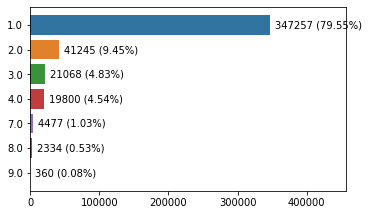

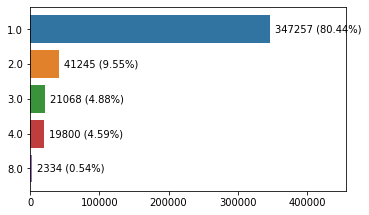

In [134]:
# CHECKUP1
df = clean_and_report(
    df, 'CHECKUP1', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Length of time since last routine checkup'
)

## Health Check, Test and Treatments

In [135]:
# Varaibles to drop
# _FLSHOT6 - Adults aged 65+ who have had a flu shot within the past year (redundant)
# _PNEUMO3 - Adults aged 65+ who have ever had a pneumonia vaccination (redundant)
# _AIDTST3 - Adults who have ever been tested for HIV (redundant)
df = df.drop(columns=['_FLSHOT6', '_PNEUMO3', '_AIDTST3'])

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 20501 (4.69%) missing records.


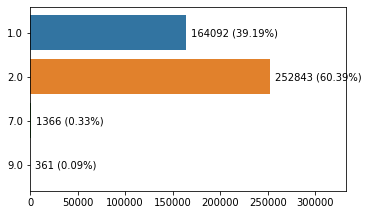

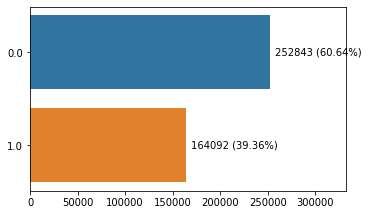

In [136]:
# FLUSHOT6
df = clean_and_report(
    df, 'FLUSHOT6', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Adult flu shot/spray past 12 mos'
)

Cleaning Steps:
[1] 777777 Don't know / Not sure -> Missing
[2] 999999 Refused -> Missing
[3] Not valid year/month from 2017 to 2018 -> Missing
[4] YY|XXXX means XXXX year at YY month, convert to the number of years apart with 2019.
There are 286369 (65.47%) missing records.


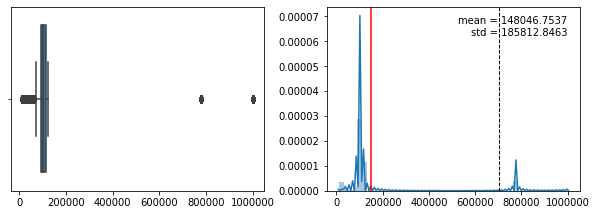

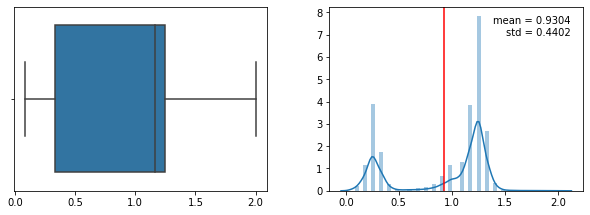

In [137]:
# FLSHTMY2
df = clean_and_report(
    df, 'FLSHTMY2', 
    [
        (lambda x: x == 777777, lambda x: np.nan, "777777 Don't know / Not sure -> Missing"),
        (lambda x: x == 999999, lambda x: np.nan, "999999 Refused -> Missing"),
        (
            lambda x: (x % 10000 < 2017) | (x % 10000 > 2018) | (x // 10000 < 1) | (x // 10000 > 12), 
            lambda x: np.nan, 
            "Not valid year/month from 2017 to 2018 -> Missing"
        ),
        (
            lambda x: (x >= 12017) & (x <= 122018),
            lambda x: 2019 - ((x % 10000) + ((x // 10000 - 1) / 12)),
            "YY|XXXX means XXXX year at YY month, convert to the number of years apart with 2019."
        )
    ], col_type='Continuous', 
    var_description='When did you (adult) receive your most recent seasonal flu shot/spray?'
)

Cleaning Steps:
[1] 77 Dont know / Not sure -> NA
[2] 99 Refused -> NA
There are 274598 (62.77%) missing records.


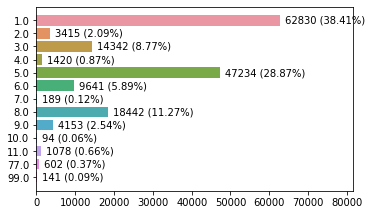

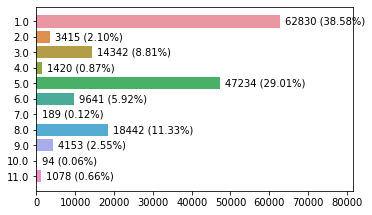

In [138]:
# IMFVPLAC
df = clean_and_report(
    df, 'IMFVPLAC', [
        (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
        (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
    ], var_description='Where did you get your last flu shot/vaccine?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 49894 (11.41%) missing records.


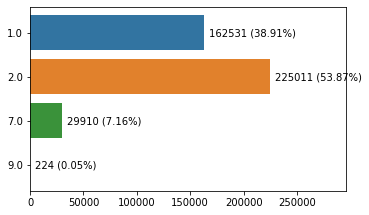

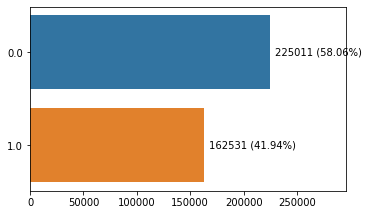

In [139]:
# PNEUVAC4
df = clean_and_report(
    df, 'PNEUVAC4', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Pneumonia shot ever'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 211201 (48.28%) missing records.


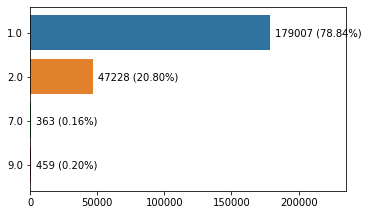

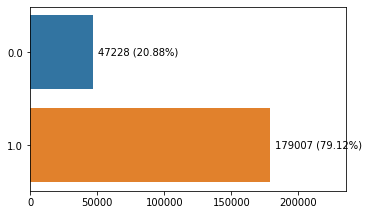

In [140]:
# HADMAM
df = clean_and_report(
    df, 'HADMAM', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have You Ever Had a Mammogram'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 261256 (59.72%) missing records.


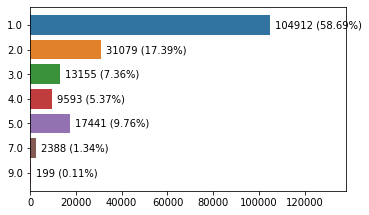

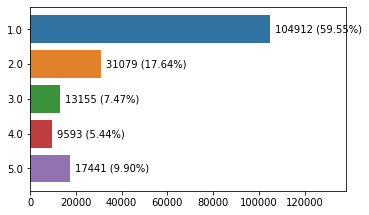

In [141]:
# HOWLONG
df = clean_and_report(
    df, 'HOWLONG', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='How Long since Last Mammogram'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 212568 (48.59%) missing records.


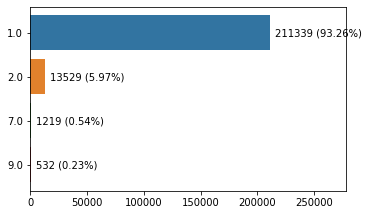

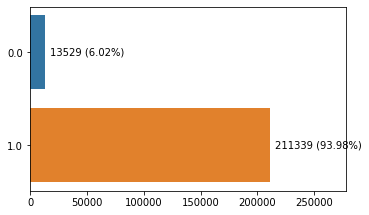

In [142]:
# HADPAP2
df = clean_and_report(
    df, 'HADPAP2', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have you ever had a Pap test?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 232914 (53.25%) missing records.


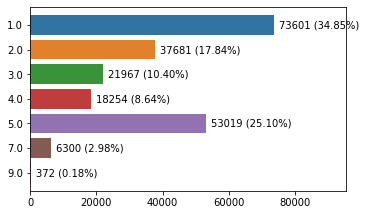

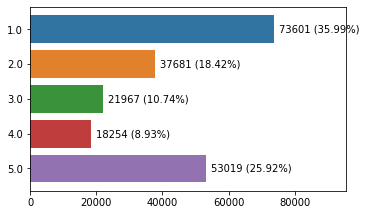

In [143]:
# LASTPAP2
df = clean_and_report(
    df, 'LASTPAP2', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='How long has it been since you had your last Pap test?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 271439 (62.05%) missing records.


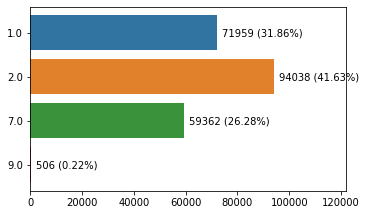

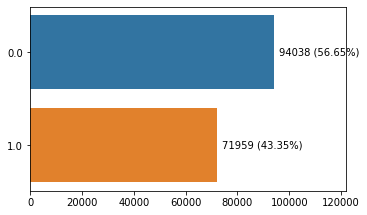

In [144]:
# HPVTEST
df = clean_and_report(
    df, 'HPVTEST', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have you ever had an HPV test?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 371293 (84.88%) missing records.


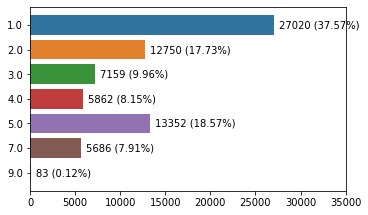

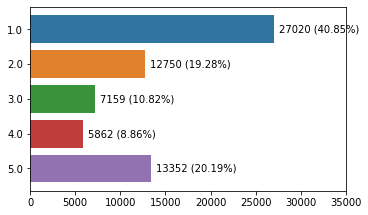

In [145]:
# HPLSTTST
df = clean_and_report(
    df, 'HPLSTTST', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='How long since your last HPV test?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 214927 (49.13%) missing records.


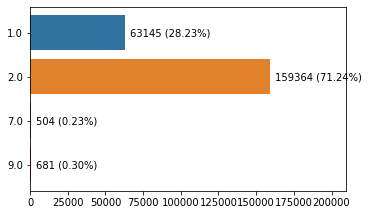

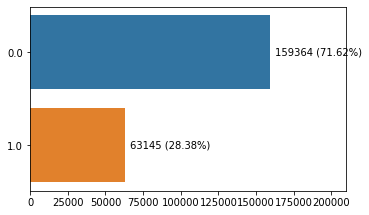

In [146]:
# HADHYST2
df = clean_and_report(
    df, 'HADHYST2', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have you had a hysterectomy?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 301827 (69.00%) missing records.


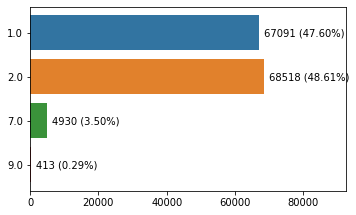

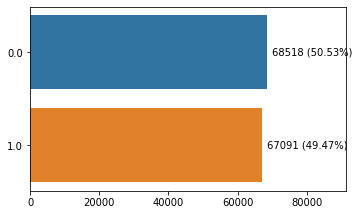

In [147]:
# PCPSAAD3
df = clean_and_report(
    df, 'PCPSAAD3', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Has a health professional EVER talked with you about the advantages of the PSA test?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 302451 (69.14%) missing records.


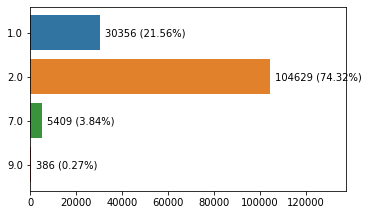

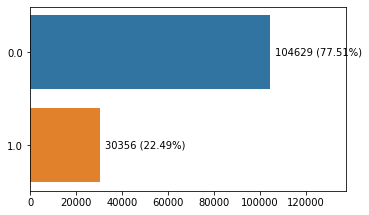

In [148]:
# PCPSADI1
df = clean_and_report(
    df, 'PCPSADI1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Has a health professional EVER talked with you about the disadvantages of the PSA test?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 303227 (69.32%) missing records.


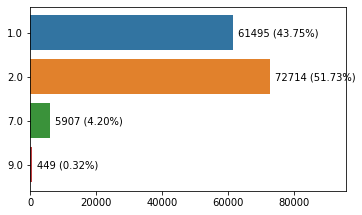

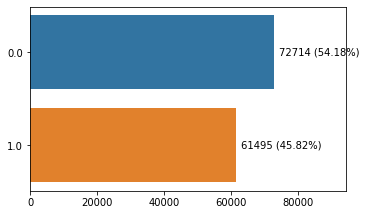

In [149]:
# PCPSARE1
df = clean_and_report(
    df, 'PCPSARE1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Has a doctor EVER recommended that you have a PSA test?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 304912 (69.70%) missing records.


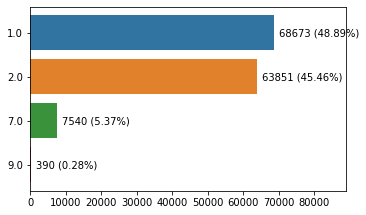

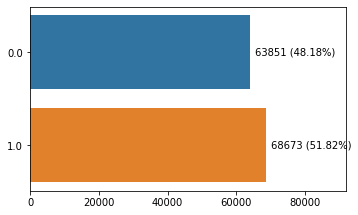

In [150]:
# PSATEST1
df = clean_and_report(
    df, 'PSATEST1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have you ever HAD a PSA test?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 370797 (84.77%) missing records.


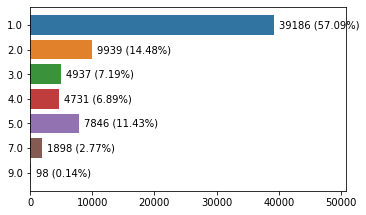

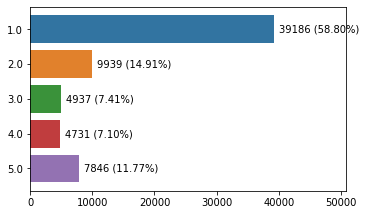

In [151]:
# PSATIME
df = clean_and_report(
    df, 'PSATIME', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Time Since Last PSA Test'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 369689 (84.51%) missing records.


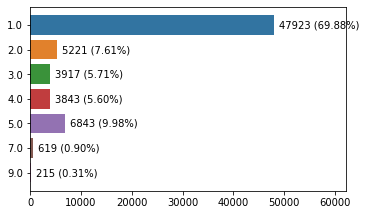

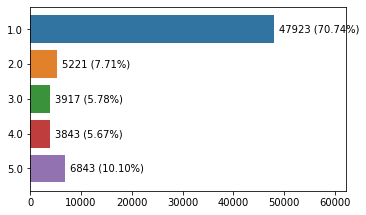

In [152]:
# PCPSARS1
df = clean_and_report(
    df, 'PCPSARS1', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='What was the MAIN reason you had this PSA test?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 171080 (39.11%) missing records.


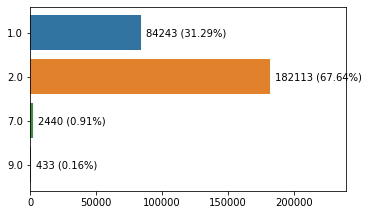

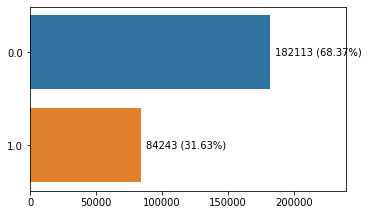

In [153]:
# BLDSTOOL
df = clean_and_report(
    df, 'BLDSTOOL', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Ever Had Blood Stool Test Using Home Kit'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 356620 (81.53%) missing records.


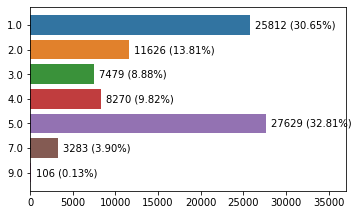

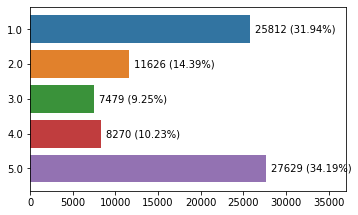

In [154]:
# LSTBLDS3
df = clean_and_report(
    df, 'LSTBLDS3', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Time Since Last Blood Stool Test'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 170839 (39.05%) missing records.


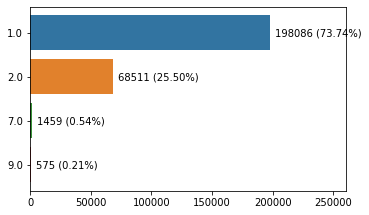

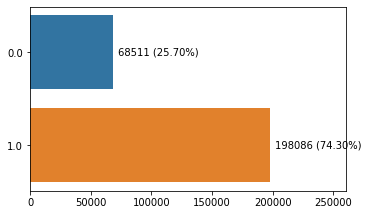

In [155]:
# HADSIGM3
df = clean_and_report(
    df, 'HADSIGM3', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Ever Had Sigmoidoscopy/Colonoscopy?'
)

Cleaning Steps:
[1] 2 Colonoscopy -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 244280 (55.84%) missing records.


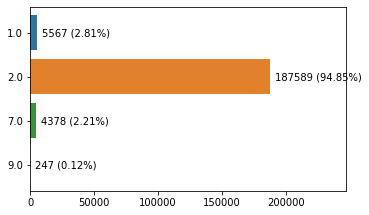

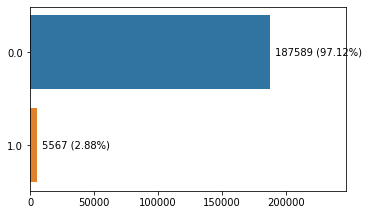

In [156]:
# HADSGCO1
df = clean_and_report(
    df, 'HADSGCO1', 
    [
        (lambda x: x == 2, lambda x: 0, "2 Colonoscopy -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Was your last test a sigmoidoscopy or colonoscopy?'
)

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 243550 (55.68%) missing records.


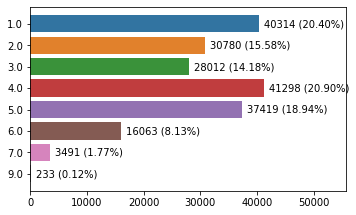

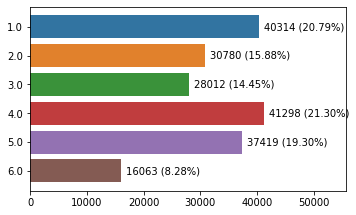

In [157]:
# LASTSIG3
df = clean_and_report(
    df, 'LASTSIG3', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='How long has it been since you had your last sigmoidoscopy or colonoscopy?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 46296 (10.58%) missing records.


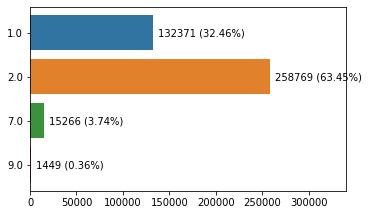

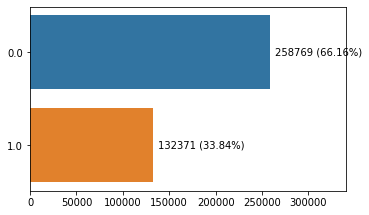

In [158]:
# HIVTST6
df = clean_and_report(
    df, 'HIVTST6', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have you ever been tested for HIV?'
)

Cleaning Steps:
[1] 777777 Don't know / Not sure -> Missing
[2] 999999 Refused -> Missing
[3] Not valid year/month from 1985 to 2019 -> Missing
[4] YY|XXXX means XXXX year at YY month, convert to the number of years apart with 2020.
There are 370898 (84.79%) missing records.


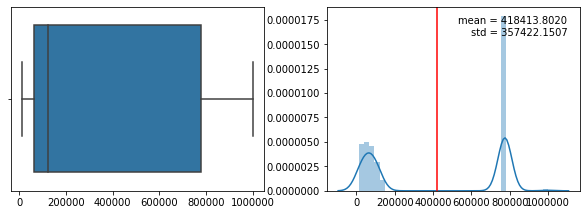

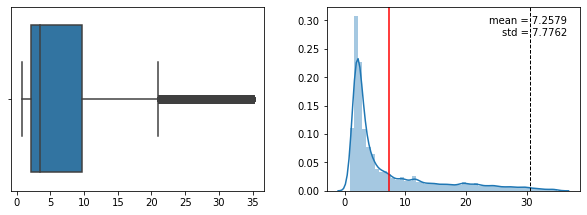

In [159]:
# HIVTSTD3
df = clean_and_report(
    df, 'HIVTSTD3', 
    [
        (lambda x: x == 777777, lambda x: np.nan, "777777 Don't know / Not sure -> Missing"),
        (lambda x: x == 999999, lambda x: np.nan, "999999 Refused -> Missing"),
        (
            lambda x: (x % 10000 < 1985) | (x % 10000 > 2019) | (x // 10000 < 1) | (x // 10000 > 12), 
            lambda x: np.nan, 
            "Not valid year/month from 1985 to 2019 -> Missing"
        ),
        (
            lambda x: (x >= 11985) & (x <= 122019),
            lambda x: 2020 - ((x % 10000) + ((x // 10000 - 1) / 12)),
            "YY|XXXX means XXXX year at YY month, convert to the number of years apart with 2020."
        )
    ], col_type='Continuous', var_description='Time (years) since last HIV test'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 32895 (7.52%) missing records.


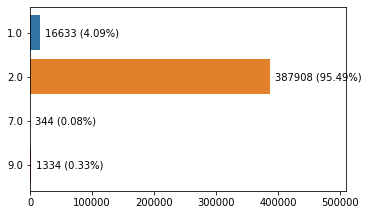

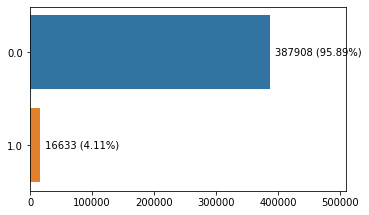

In [160]:
# HIVRISK5
df = clean_and_report(
    df, 'HIVRISK5', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Do Any High Risk Situations Apply?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Don't know / Not sure -> Missing
[3] 9 Refused -> Missing
There are 357087 (81.63%) missing records.


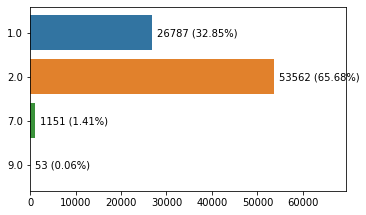

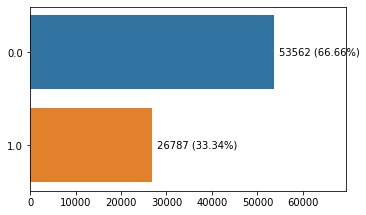

In [161]:
# COPDBTST
df = clean_and_report(
    df, 'COPDBTST', 
    [
        (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Have you ever been given a breathing test?'
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 395414 (90.39%) missing records.


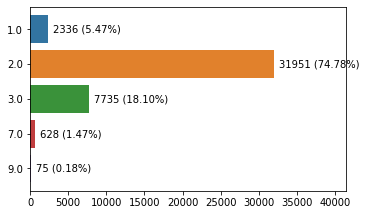

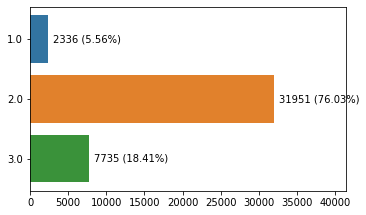

In [162]:
# Cleaning LCSCTSCN - Did you have a CT or CAT scan?
clean_steps_LCSCTSCN = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'LCSCTSCN', clean_steps_LCSCTSCN,
    var_description='In the last 12 months, did you have a CT or CAT scan?'
)

Cleaning Steps:
[1] 9 Refused -> NA
There are 436690 (99.83%) missing records.


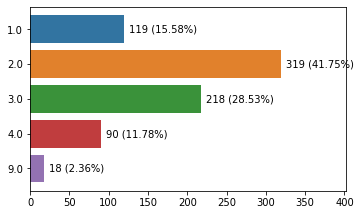

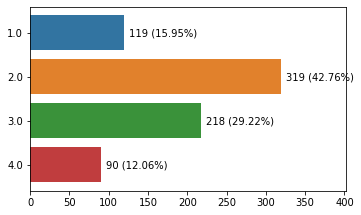

In [163]:
# Cleaning PCPSADE1 - Which of the following best describes the decision to have the P.S.A. test done?
clean_steps_PCPSADE1 = [
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA')
]
df = clean_and_report(df, 'PCPSADE1', clean_steps_PCPSADE1, var_description='Why was PSA test done?')

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 426770 (97.56%) missing records.


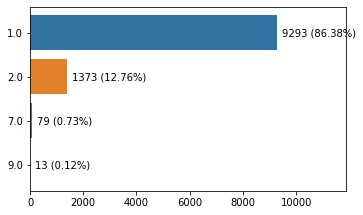

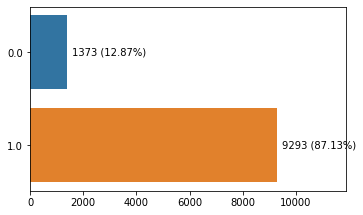

In [164]:
# Cleaning PROFEXAM - Ever Had Breast Physical Exam by Doctor
clean_steps_PROFEXAM = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'PROFEXAM', clean_steps_PROFEXAM, 
    var_description='Ever Had Breast Physical Exam by Doctor'
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 428320 (97.92%) missing records.


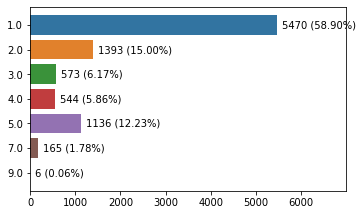

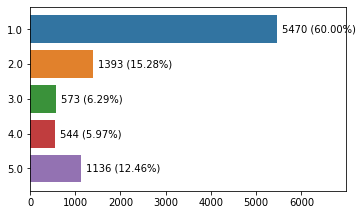

In [165]:
# Cleaning LENGEXAM - How Long since Last Breast Physical Exam
clean_steps_LENGEXAM = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'LENGEXAM', clean_steps_LENGEXAM,
    var_description='How long has it been since your last breast exam?'
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 422547 (96.60%) missing records.


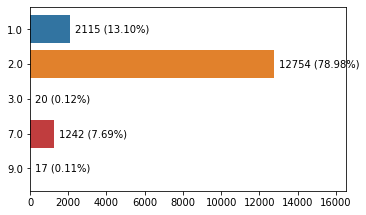

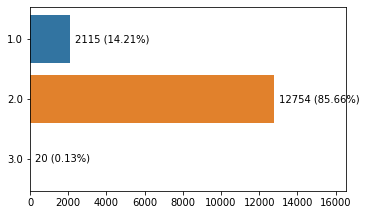

In [166]:
# Cleaning HPVADVC2 -  Have you ever had the HPV vaccination?
clean_steps_HPVADVC2 = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'HPVADVC2', clean_steps_HPVADVC2,
    var_description='Have you ever had the HPV vaccination?'
)

Cleaning Steps:
[1] More than 3 three shots -> 3 shots
[2] 77 Dont know / Not sure -> NA
[3] 99 Refused -> NA
There are 435696 (99.60%) missing records.


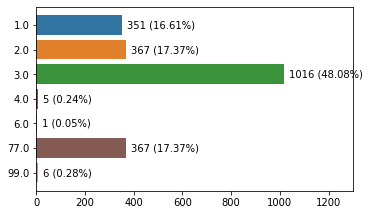

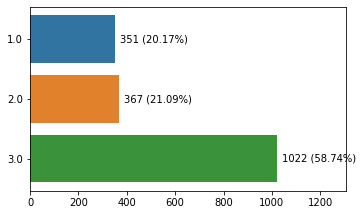

In [167]:
# Cleaning HPVADSHT - How many HPV shots did you receive?
clean_steps_HPVADSHT = [
    (lambda x: (x == 4) | (x == 6), lambda x: 3, 'More than 3 three shots -> 3 shots'),
    (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
    (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
]
df = clean_and_report(
    df, 'HPVADSHT', clean_steps_HPVADSHT,
    var_description='How many HPV shots did you receive?'
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 410995 (93.96%) missing records.


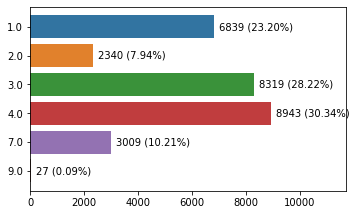

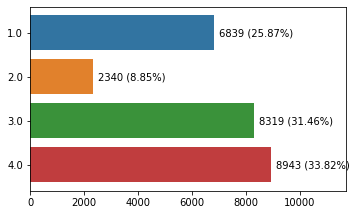

In [168]:
# Cleaning TETANUS1 - Received Tetanus Shot Since 2005?
clean_steps_TETANUS1 = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'TETANUS1', clean_steps_TETANUS1,
    var_description='Received Tetanus Shot Since 2005?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 418974 (95.78%) missing records.


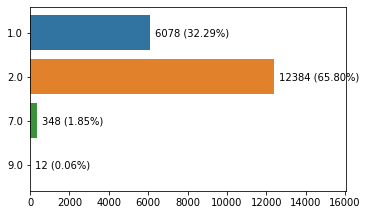

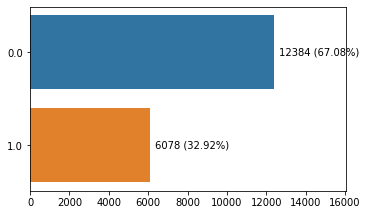

In [169]:
# Cleaning SHINGLE2 - Have you ever had the shingles or zoster vaccine?
clean_steps_SHINGLE2 = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'SHINGLE2', clean_steps_SHINGLE2,
    var_description='Have you ever had the shingles or zoster vaccine?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 9 Don't know/Not Sure/Refused -> NA
There are 263679 (60.28%) missing records.


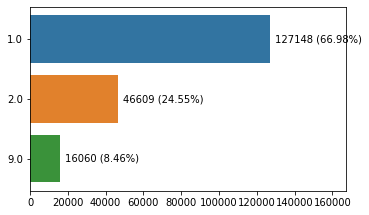

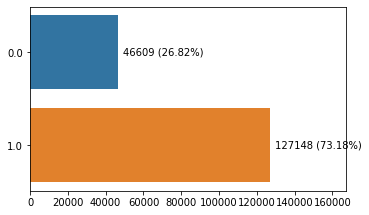

In [170]:
# _RFMAM21
clean_steps_RFMAM21 = [
    (lambda x: x == 2, lambda x: 0, '2 No -> 0'),
    (lambda x: x == 9, lambda x: np.nan, "9 Don't know/Not Sure/Refused -> NA"),
]
df = clean_and_report(
    df, '_RFMAM21', clean_steps_RFMAM21,
    var_description='Women respondents aged 40+ who have had a mammogram in the past two years'
)

Cleaning Steps:
[1] 2 Did not receive a mammogram within the past 2 years -> 0
There are 326990 (74.75%) missing records.


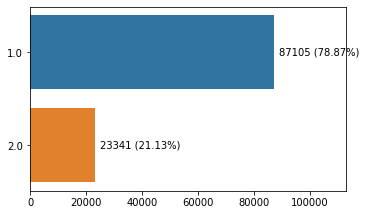

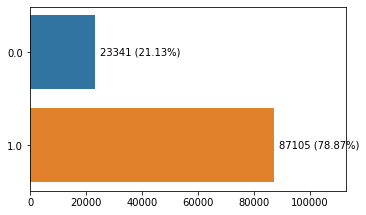

In [171]:
# _MAM5022
df = clean_and_report(
    df, '_MAM5022', [
        (lambda x: x == 2, lambda x: 0, '2 Did not receive a mammogram within the past 2 years -> 0'),
    ], var_description='Women respondents aged 50-74 that have had a mammogram in the past two years'
)

Cleaning Steps:
[1] 2 Did not receive a Pap test within the past 3 years -> 0
There are 330083 (75.46%) missing records.


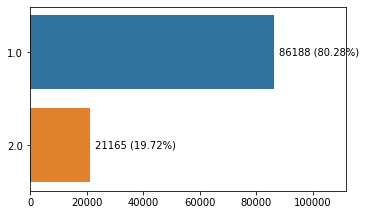

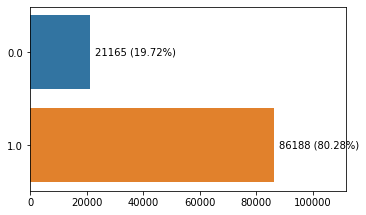

In [172]:
# _RFPAP34
df = clean_and_report(
    df, '_RFPAP34', [
        (lambda x: x == 2, lambda x: 0, '2 Did not receive a Pap test within the past 3 years -> 0'),
    ], var_description='Women respondents aged 21-65 who have had a pap test in the past three years'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 9 Don't know/Not Sure/Refused -> NA
There are 309398 (70.73%) missing records.


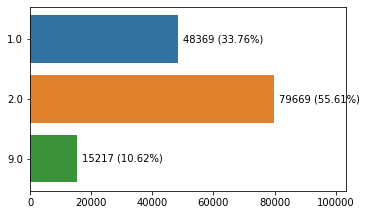

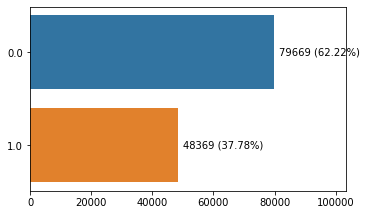

In [173]:
# _RFPSA22
clean_steps_RFPSA22 = [
    (lambda x: x == 2, lambda x: 0, '2 No -> 0'),
    (lambda x: x == 9, lambda x: np.nan, "9 Don't know/Not Sure/Refused -> NA"),
]
df = clean_and_report(
    df, '_RFPSA22', clean_steps_RFPSA22,
    var_description='Male respondents aged 40+ who have had a PSA test in the past 2 years'
)


Cleaning Steps:
[1] 2 Have not had a blood stool test in the past year -> 0
There are 231884 (53.01%) missing records.


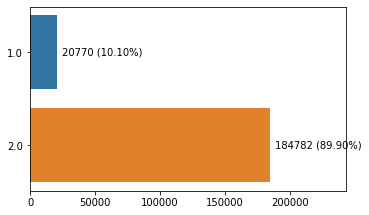

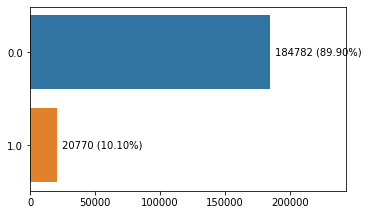

In [174]:
# _RFBLDS3
df = clean_and_report(
    df, '_RFBLDS3', [
        (lambda x: x == 2, lambda x: 0, '2 Have not had a blood stool test in the past year -> 0')
    ], var_description='Respondents aged 50-75 who have had a blood stool test within the past year'
)


Cleaning Steps:
[1] 2 Did not receive a colonoscopy within the past 10 years -> 0
There are 236592 (54.09%) missing records.


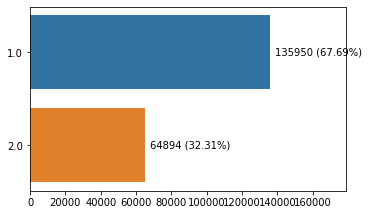

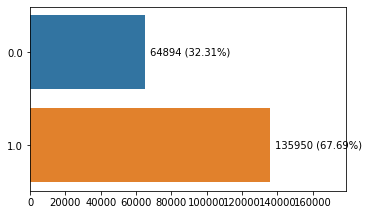

In [175]:
# _COL10YR
df = clean_and_report(
    df, '_COL10YR', [
        (lambda x: x == 2, lambda x: 0, '2 Did not receive a colonoscopy within the past 10 years -> 0')
    ], var_description='Respondents aged 50-75 that who have had a colonoscopy in the past 10 years'
)

Cleaning Steps:
[1] 2 Did not receive a home FOBT within the past 3 years -> 0
There are 231884 (53.01%) missing records.


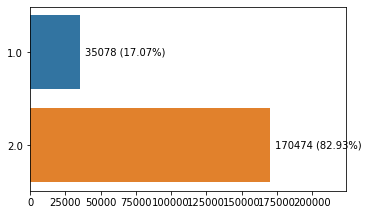

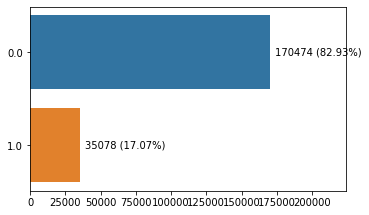

In [176]:
# _HFOB3YR
df = clean_and_report(
    df, '_HFOB3YR', [
        (lambda x: x == 2, lambda x: 0, '2 Did not receive a home FOBT within the past 3 years -> 0')
    ], var_description='Respondents aged 50-75 who have had a blood stool test within the past 3 years'
)


Cleaning Steps:
[1] 2 Did not receive a sigmoidoscopy within the past 5 years -> 0
There are 342470 (78.29%) missing records.


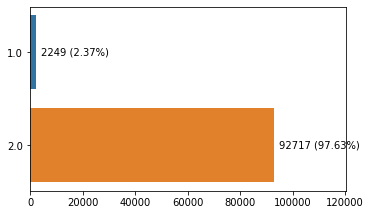

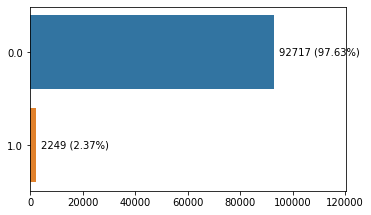

In [177]:
# _FS5YR
df = clean_and_report(
    df, '_FS5YR', [
        (lambda x: x == 2, lambda x: 0, '2 Did not receive a sigmoidoscopy within the past 5 years -> 0')
    ], var_description='Respondents aged 50-75 who have had a sigmoidoscopy within the past 5 years'
)


Cleaning Steps:
[1] 2 Did not receive a sigmoidoscopy within the past 5 years or did not receive a blood stool test within the past 3 years -> 0
There are 249349 (57.00%) missing records.


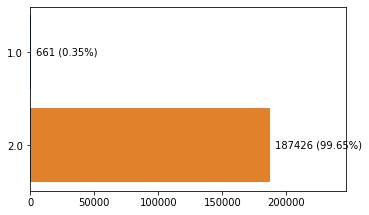

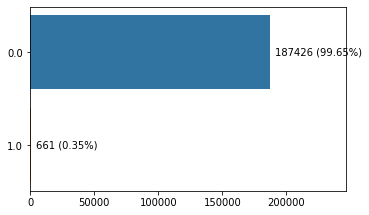

In [178]:
# _FOBTFS
df = clean_and_report(
    df, '_FOBTFS', [
        (lambda x: x == 2, lambda x: 0, '2 Did not receive a sigmoidoscopy within the past 5 years or did not receive a blood stool test within the past 3 years -> 0')
    ], var_description='Respondents aged 50-75 who have had a blood stool test within the past 3 years and a sigmoidoscopy within the past 5 years'
)


Cleaning Steps:
[1] 2 Did not receive one or more of the recommended CRC tests within the recommended time interval -> 0
There are 235745 (53.89%) missing records.


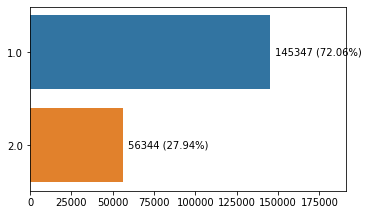

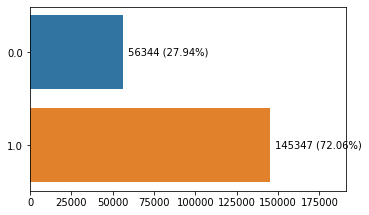

In [179]:
# _CRCREC
df = clean_and_report(
    df, '_CRCREC', [
        (lambda x: x == 2, lambda x: 0, '2 Did not receive one or more of the recommended CRC tests within the recommended time interval -> 0')
    ], var_description='Respondents aged 50-75 who have fully met the USPSTF recommendation'
)


## Cancer

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 431244 (98.58%) missing records.


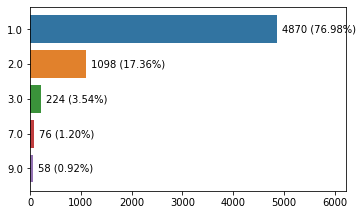

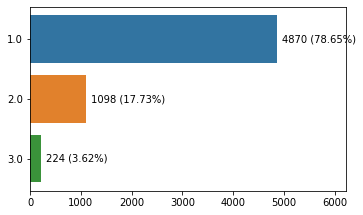

In [180]:
# Cleaning CNCRDIFF - How many types of cancer?
clean_steps_CNCRDIFF = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CNCRDIFF', clean_steps_CNCRDIFF, 
    var_description='How many different types of cancer have you had?'
)

Cleaning Steps:
[1] 98 Dont know / Not sure -> NA
[2] 99 Refused -> NA
There are 431557 (98.66%) missing records.


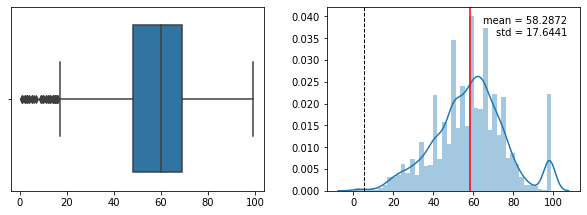

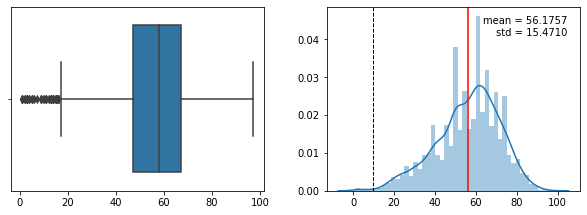

In [181]:
# Cleaning CNCRAGE - Age told had cancer
clean_steps_CNCRAGE = [
    (lambda x: x == 98, lambda x: np.nan, '98 Dont know / Not sure -> NA'),
    (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
]
df = clean_and_report(df, 'CNCRAGE', clean_steps_CNCRAGE, var_description='Age Told Had Cancer')

Cleaning Steps:
[1] 77 Dont know / Not sure -> NA
[2] 99 Refused -> NA
There are 431567 (98.66%) missing records.


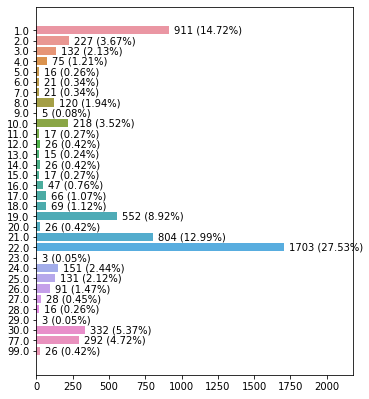

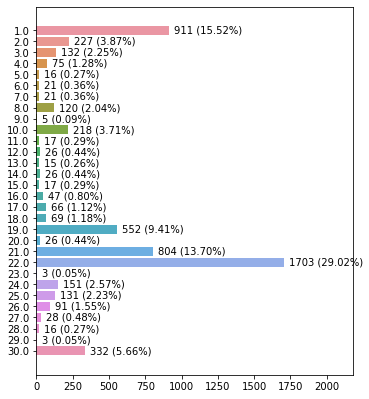

In [182]:
# Cleaning CNCRTYP1 - Type of Cancer
clean_steps_CNCRTYP1 = [
    (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
    (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
]
df = clean_and_report(
    df, 'CNCRTYP1', clean_steps_CNCRTYP1, 
    col_type='Categorical', fig_size=(5, 6),
    var_description='Type of Cancer'
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 431403 (98.62%) missing records.


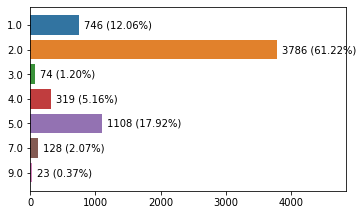

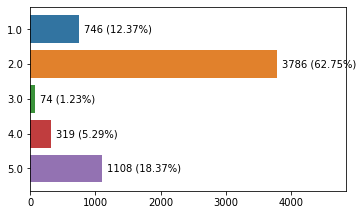

In [183]:
# Cleaning CSRVTRT2 - Currently receiving treatment for cancer
clean_steps_CSRVTRT2 = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVTRT2', clean_steps_CSRVTRT2,
    var_description='Currently Receiving Treatment for Cancer'
)

Cleaning Steps:
[1] 77 Dont know / Not sure -> NA
[2] 99 Refused -> NA
There are 433762 (99.16%) missing records.


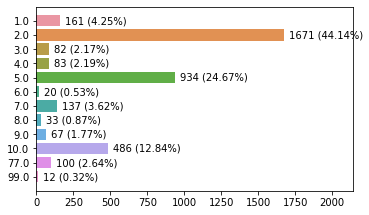

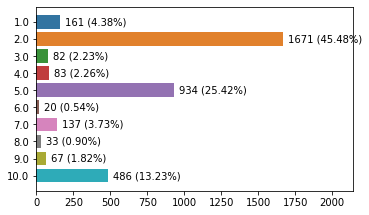

In [184]:
# Cleaning CSRVDOC1 - What type of doctor provides the majority of your health care?
clean_steps_CSRVDOC1 = [
    (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
    (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVDOC1', clean_steps_CSRVDOC1,
    var_description='What type of doctor provides the majority of your health care (when you have cancer)?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 433942 (99.20%) missing records.


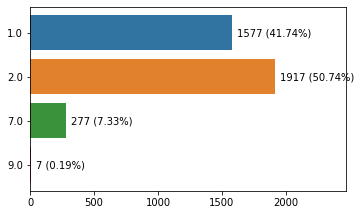

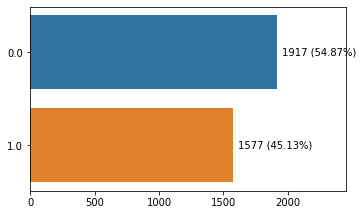

In [185]:
# Cleaning CSRVSUM - Did You Receive a Summary of Cancer Treatments Received
clean_steps_CSRVSUM = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVSUM', clean_steps_CSRVSUM,
    var_description='Did You Receive a Summary of Cancer Treatments Received'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 433749 (99.16%) missing records.


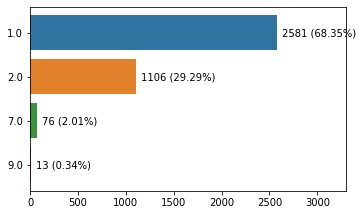

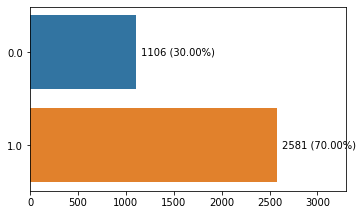

In [186]:
# Cleaning CSRVRTRN - Ever receive instructions from a doctor for follow-up check-ups
clean_steps_CSRVRTRN = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVRTRN', clean_steps_CSRVRTRN,
    var_description='Ever Receive Instructions From A Doctor For Follow-Up Check-Ups'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 435066 (99.46%) missing records.


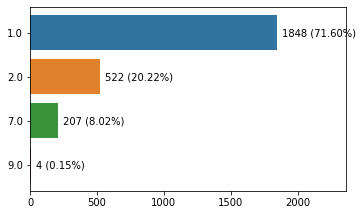

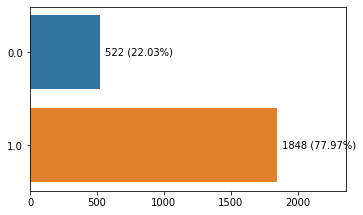

In [187]:
# Cleaning CSRVINST - Were these instrcutions written down or printed on paper for you?
clean_steps_CSRVINST = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVINST', clean_steps_CSRVINST,
    var_description='Were these instructions written down or printed on paper for you?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 433712 (99.15%) missing records.


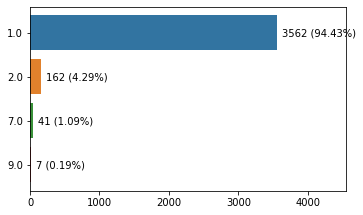

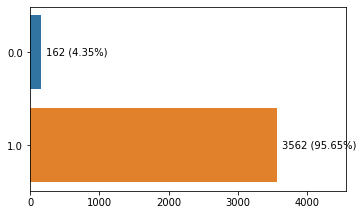

In [188]:
# Cleaning CSRVINSR - Did Health Insurance Pay For All Of Your Cancer Treatment
clean_steps_CSRVINSR = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVINSR', clean_steps_CSRVINSR,
    var_description='Did Health Insurance Pay For All Of Your Cancer Treatment'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 433687 (99.14%) missing records.


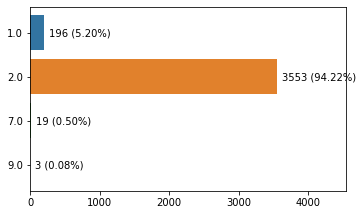

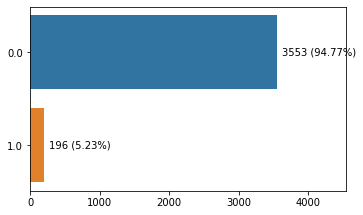

In [189]:
# Cleaning CSRVDEIN - Ever Denied Insurance Coverage Because Of Your Cancer?
clean_steps_CSRVDEIN = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVDEIN', clean_steps_CSRVDEIN,
    'Ever Denied Insurance Coverage Because Of Your Cancer?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 433716 (99.15%) missing records.


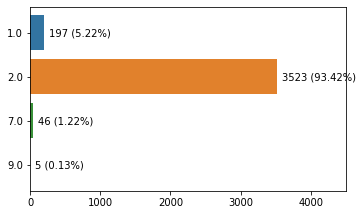

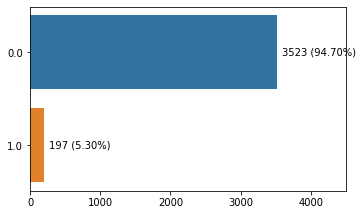

In [190]:
# Cleaning CSRVCLIN - Participate In Clinical Trial As Part Of Cancer Treatment?
clean_steps_CSRVCLIN = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVCLIN', clean_steps_CSRVCLIN,
    var_description='Did you participate in a clinical trial as part of your cancer treatment?'
)

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 433683 (99.14%) missing records.


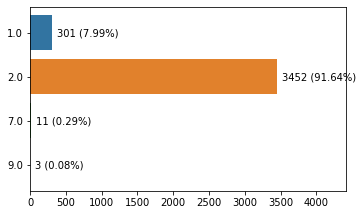

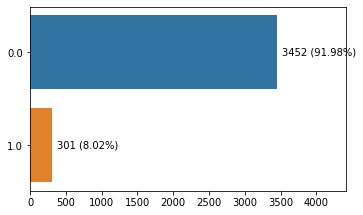

In [191]:
# Cleaning CSRVPAIN - Do you currently have physical pain caused by your cancer or cancer treatment?
clean_steps_CSRVPAIN = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVPAIN', clean_steps_CSRVPAIN,
    var_description='Do you currently have physical pain caused by your cancer or cancer treatment?'
)

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 437147 (99.93%) missing records.


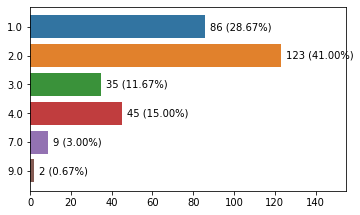

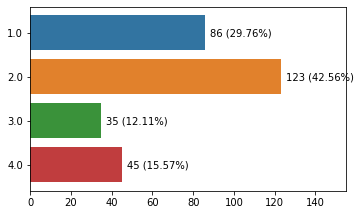

In [192]:
# Cleaning CSRVCTL1 -  Is your pain currently under control?
clean_steps_CSRVCTL1 = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(
    df, 'CSRVCTL1', clean_steps_CSRVCTL1,
    var_description='Is your pain currently under control?'
)

## Oral Health

In [193]:
# Variables to drop
# _EXTETH3 - binary of RMVTETH4
# _ALTETH3 - redudant of RMVTETH4
# _DENVST3 - redundant of LASTDEN4
df = df.drop(columns=['_EXTETH3', '_ALTETH3', '_DENVST3'])

Cleaning Steps:
[1] 7 Don't know / Not sure -> Missing
[2] 9 Refused -> Missing
There are 4760 (1.09%) missing records.


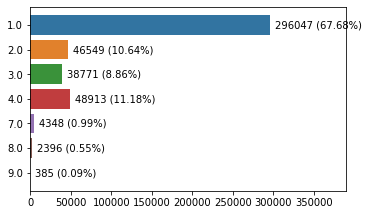

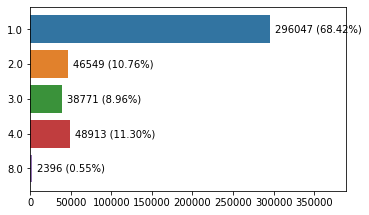

In [194]:
# LASTDEN4
df = clean_and_report(
    df, 'LASTDEN4', 
    [
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> Missing"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> Missing")
    ], var_description='Time of last visited dentist or dental clinic'
)

Cleaning Steps:
[1] 8 None -> 0
[2] 7 Don't know / Not sure -> NA
[3] 9 Refused -> NA
There are 10422 (2.38%) missing records.


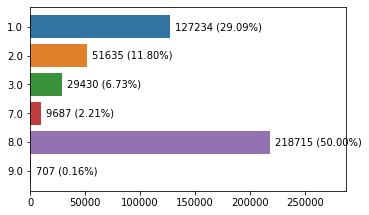

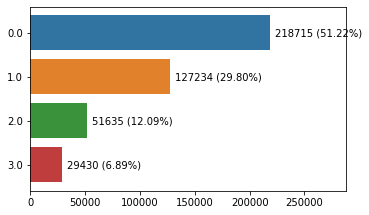

In [195]:
# RMVTETH4
df = clean_and_report(
    df, 'RMVTETH4', 
    [
        (lambda x: x == 8, lambda x: 0, "8 None -> 0"),
        (lambda x: x == 7, lambda x: np.nan, "7 Don't know / Not sure -> NA"),
        (lambda x: x == 9, lambda x: np.nan, "9 Refused -> NA")
    ], var_description='Number of Permanent Teeth Removed'
)

## Children

In [196]:
# Drop _CPRACE - Preferred Child Race Categories, redundant of _CRACE1
df = df.drop(columns=['_CPRACE'])

Cleaning Steps:
[1] 2 Girl -> 0
[2] 9 Refused -> NA
There are 378502 (86.53%) missing records.


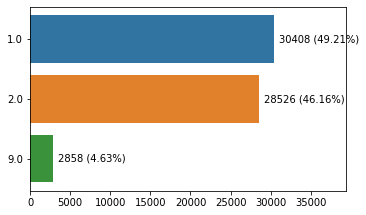

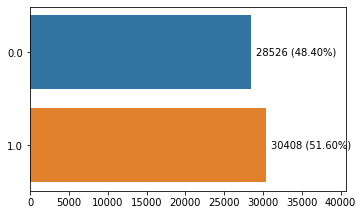

In [197]:
# Cleaning RCSGENDR - Gender of child
clean_steps_RCSGENDR = [
    (lambda x: x == 2, lambda x: 0, "2 Girl -> 0"),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA')
]
df = clean_and_report(df, 'RCSGENDR', clean_steps_RCSGENDR, var_description='Gender of child')

Cleaning Steps:
[1] 7 Dont know / Not sure -> NA
[2] 9 Refused -> NA
There are 377915 (86.39%) missing records.


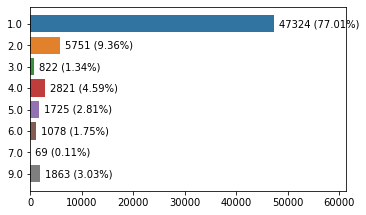

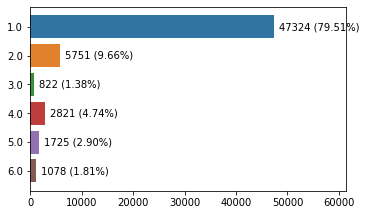

In [198]:
# Cleaning RCSRLTN2 - Relationship to child
clean_steps_RCSRLTN2 = [
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(df, 'RCSRLTN2', clean_steps_RCSRLTN2, var_description='Relationship to child')

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 385936 (88.23%) missing records.


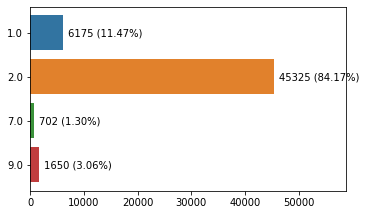

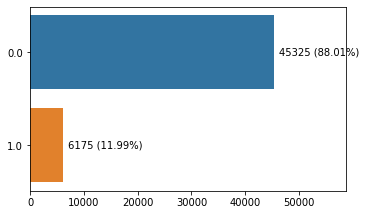

In [199]:
# Cleaning CASTHDX2 - Has a doctor, nurse or other health professional EVER said that the child has asthma
clean_steps_CASTHDX2 = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(df, 'CASTHDX2', clean_steps_CASTHDX2, var_description='Ever told child has asthma')

Cleaning Steps:
[1] 2 No -> 0
[2] 7 Dont know / Not sure -> NA
[3] 9 Refused -> NA
There are 431416 (98.62%) missing records.


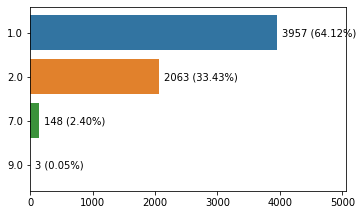

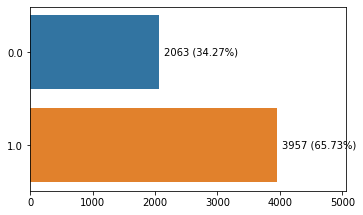

In [200]:
# Cleaning CASTHNO2 - Does the child still have asthma?
clean_steps_CASTHNO2 = [
    (lambda x: x == 2, lambda x: 0, "2 No -> 0"),
    (lambda x: x == 7, lambda x: np.nan, '7 Dont know / Not sure -> NA'),
    (lambda x: x == 9, lambda x: np.nan, '9 Refused -> NA'),
]
df = clean_and_report(df, 'CASTHNO2', clean_steps_CASTHNO2, var_description='Child still have asthma?')

Cleaning Steps:
[1] 9 Don't know/Not Sure/Refused/Missing -> NA
There are 374709 (85.66%) missing records.


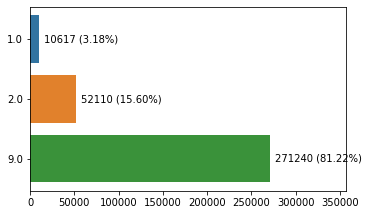

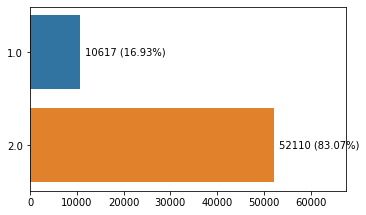

In [201]:
# Cleaning _CHISPNC - Child Hispanic, Latino/a, or Spanish origin calculated variable
clean_steps_CHISPNC = [
    (lambda x: x == 9, lambda x: np.nan, "9 Don't know/Not Sure/Refused/Missing -> NA"),
]
df = clean_and_report(
    df, '_CHISPNC', clean_steps_CHISPNC, 
    var_description='Child Hispanic, Latino/a, or Spanish origin'
)

Cleaning Steps:
[1] 77 Dont know / Not sure -> NA
[2] 99 Refused -> NA
There are 375481 (85.84%) missing records.


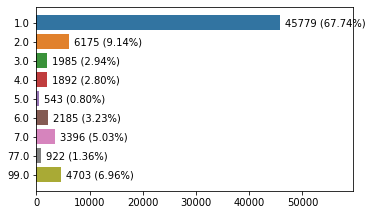

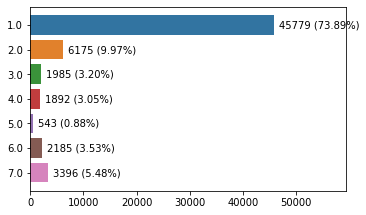

In [202]:
# Cleaning _CRACE1 - Preferred Child Race Categories
clean_steps_CRACE1 = [
    (lambda x: x == 77, lambda x: np.nan, '77 Dont know / Not sure -> NA'),
    (lambda x: x == 99, lambda x: np.nan, '99 Refused -> NA'),
]
df = clean_and_report(
    df, '_CRACE1', clean_steps_CRACE1, 
    var_description='Child multiracial race categorization'
)

## Care Giver

In [203]:
# All variables in this category has less than 5% respondants, and not much related to topic.
# Drop them all
# CAREGIV1 - Provided regular care for family or friend
# CRGVREL2 - Relationship Of Person To Whom You Are Giving Care
# CRGVLNG1 - How Long Provided Care For Person.
# CRGVHRS1 - How Many Hours Do You Provide Care For Person?
# CRGVPRB2 - What Is The Major Health Problem, Illness, Disability For Care For Person?
# CRGVPERS - Managing personal care such as giving medications, feeding, dressing, or bathing
# CRGVHOUS - Managing household tasks such as cleaning, managing money, or preparing meals
# CRGVMST3 - Which support do you MOST need that you are not getting?
# CRGVEXPT - Do you expect to have a relative you will need to provide care for?
df = df.drop(columns=[
    'CAREGIV1', 'CRGVREL2', 'CRGVLNG1', 'CRGVHRS1', 'CRGVPRB2',
    'CRGVPERS', 'CRGVHOUS', 'CRGVMST3', 'CRGVEXPT' 
])

## Variables not in Codebook
There are some variables not in codebook, drop them.

In [204]:
df = df.drop(columns=[
    'ADDOWN1', 'ADPLEAS1', 'FEELNERV', 'FEETCHK3',
    'MARIJAN1', 'PCDMDEC1', 'STOPWORY'
])

# Missing Value for All Variables

In [205]:
na_percentage_df = (
    df
    .apply(lambda x: x.isna().sum() / len(x) * 100)
    .sort_values(ascending=False)
    .to_frame(name='NA %')
    .rename_axis('Variable')
    .reset_index()
)
na_percentage_df.to_csv('Data/LLCP2018_NA_percentage.csv', index=False)

In [206]:
for lim in range(90, 49, -10):
    print(
        'Number of variables with NA percentage {:d}% or higher: {:d}/{:d}'
        .format(lim, (na_percentage_df['NA %'] >= lim).sum(), len(na_percentage_df))
    )

Number of variables with NA percentage 90% or higher: 52/187
Number of variables with NA percentage 80% or higher: 80/187
Number of variables with NA percentage 70% or higher: 85/187
Number of variables with NA percentage 60% or higher: 96/187
Number of variables with NA percentage 50% or higher: 112/187


# Save Data

In [207]:
df.shape

(437436, 187)

In [208]:
df.to_csv('Data/LLCP2018_cleaned.csv.gz', index=False)